In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from math import pi

warnings.filterwarnings('ignore')

# display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
flight_data = pd.read_csv('Dataset/Flight_Level_Data.csv')
pnr_flight_data = pd.read_csv('Dataset/PNR_Flight_Level_Data.csv')
pnr_remarks_data = pd.read_csv('Dataset/PNR_Remark_Level_Data.csv')
airports_data = pd.read_csv('Dataset/Airports_Data.csv')
bag_data = pd.read_csv('Dataset/Bag_Level_Data.csv')

print("Dataset Shapes:")
print(f"Flight Data: {flight_data.shape}")
print(f"PNR Flight Data: {pnr_flight_data.shape}")
print(f"PNR Remarks Data: {pnr_remarks_data.shape}")
print(f"Airports Data: {airports_data.shape}")
print(f"Bag Data: {bag_data.shape}")

Dataset Shapes:
Flight Data: (8099, 15)
PNR Flight Data: (687878, 12)
PNR Remarks Data: (51698, 4)
Airports Data: (5612, 2)
Bag Data: (687245, 8)


In [4]:
print("\n=== FLIGHT DATA SAMPLE ===")
print(flight_data.head())
print("\n=== FLIGHT DATA INFO ===")
print(flight_data.info())
print("\n=== MISSING VALUES ===")
print(flight_data.isnull().sum())


=== FLIGHT DATA SAMPLE ===
  company_id  flight_number scheduled_departure_date_local  \
0         OO           4792                     2025-08-04   
1         UA            920                     2025-08-03   
2         UA           1776                     2025-08-10   
3         OO           5790                     2025-08-06   
4         UA           1398                     2025-08-05   

  scheduled_departure_station_code scheduled_arrival_station_code  \
0                              ORD                            ROA   
1                              ORD                            LHR   
2                              ORD                            PHL   
3                              ORD                            CRW   
4                              ORD                            ATL   

  scheduled_departure_datetime_local scheduled_arrival_datetime_local  \
0               2025-08-04T17:57:00Z             2025-08-04T21:04:00Z   
1               2025-08-03T18:05:00Z  

In [6]:
def convert_datetime_columns(df, datetime_cols):
    """Convert string columns to datetime"""
    for col in datetime_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

# convert flight data datetime columns
flight_datetime_cols = [
    'scheduled_departure_datetime_local',
    'scheduled_arrival_datetime_local',
    'actual_departure_datetime_local',
    'actual_arrival_datetime_local'
]
flight_data = convert_datetime_columns(flight_data, flight_datetime_cols)
flight_data['scheduled_departure_date_local'] = pd.to_datetime(
    flight_data['scheduled_departure_date_local'], errors='coerce'
)

# PNR data datetime columns
pnr_flight_data['scheduled_departure_date_local'] = pd.to_datetime(
    pnr_flight_data['scheduled_departure_date_local'], errors='coerce'
)
pnr_flight_data['pnr_creation_date'] = pd.to_datetime(
    pnr_flight_data['pnr_creation_date'], errors='coerce'
)

# bag data datetime columns
bag_data['scheduled_departure_date_local'] = pd.to_datetime(
    bag_data['scheduled_departure_date_local'], errors='coerce'
)
bag_data['bag_tag_issue_date'] = pd.to_datetime(
    bag_data['bag_tag_issue_date'], errors='coerce'
)

print("Datetime conversion done")

Datetime conversion done


In [7]:
# flight Identifier
def create_flight_id(df):
    """Create unique flight identifier"""
    df['flight_id'] = (
        df['company_id'].astype(str) + '_' +
        df['flight_number'].astype(str) + '_' +
        df['scheduled_departure_date_local'].astype(str) + '_' +
        df['scheduled_departure_station_code'].astype(str) + '_' +
        df['scheduled_arrival_station_code'].astype(str)
    )
    return df

flight_data = create_flight_id(flight_data)
pnr_flight_data = create_flight_id(pnr_flight_data)
bag_data = create_flight_id(bag_data)

print(f"Flight IDs created. Unique flights: {flight_data['flight_id'].nunique()}")

Flight IDs created. Unique flights: 8063


In [8]:
# departure Delay
flight_data['departure_delay_minutes'] = (
    (flight_data['actual_departure_datetime_local'] - 
     flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60
)

# handle missing actual departure times (if any)
flight_data['is_delayed'] = flight_data['departure_delay_minutes'] > 0
flight_data['departure_delay_minutes'] = flight_data['departure_delay_minutes'].fillna(0)

print(f"Departure delays calculated. Avg delay: {flight_data['departure_delay_minutes'].mean():.2f} mins")

Departure delays calculated. Avg delay: 21.18 mins


In [9]:
# check the actual bag types in the data
print("Bag Data columns:", bag_data.columns.tolist())
print("\nUnique bag types:", bag_data['bag_type'].unique())
print("\nBag type counts:")
print(bag_data['bag_type'].value_counts())

bag_features = bag_data.groupby('flight_id').agg({
    'bag_tag_unique_number': 'count',  # Total bags
}).reset_index()
bag_features.columns = ['flight_id', 'total_bags']

# bag type counts
bag_type_counts = bag_data.groupby(['flight_id', 'bag_type']).size().unstack(fill_value=0)
bag_type_counts = bag_type_counts.reset_index()

# merging bag type counts with bag features
bag_features = bag_features.merge(bag_type_counts, on='flight_id', how='left')

# based on the data structure, we have: 'Origin', 'Transfer', 'Hot Transfer'
bag_type_cols = ['Origin', 'Transfer', 'Hot Transfer']
for col in bag_type_cols:
    if col not in bag_features.columns:
        bag_features[col] = 0
    else:
        bag_features[col] = bag_features[col].fillna(0)

# rename columns for redability
if 'Origin' in bag_features.columns:
    bag_features.rename(columns={'Origin': 'checked_bags'}, inplace=True)
if 'Transfer' in bag_features.columns:
    bag_features.rename(columns={'Transfer': 'transfer_bags'}, inplace=True)
if 'Hot Transfer' in bag_features.columns:
    bag_features.rename(columns={'Hot Transfer': 'hot_transfer_bags'}, inplace=True)


### --------- FIX -------------
# Hot transfer bags (connection time < 30 mins)
# Note: This requires connection time data which might need to be engineered
# For now, we'll use a proxy or mark this for future enhancement

# transfer ratio (transfer bags / checked bags)
bag_features['transfer_ratio'] = np.where(
    bag_features['checked_bags'] > 0,
    bag_features['transfer_bags'] / bag_features['checked_bags'],
    np.where(bag_features['transfer_bags'] > 0, 1, 0)  # If no checked bags but has transfers
)

# hot transfer ratio
bag_features['hot_transfer_ratio'] = np.where(
    bag_features['transfer_bags'] > 0,
    bag_features['hot_transfer_bags'] / bag_features['transfer_bags'],
    0
)

# bags per seat (will calculate after merging with flight data)
print("Bag features aggregated:")
print(bag_features.head())
print(f"\nBag features shape: {bag_features.shape}")

Bag Data columns: ['company_id', 'flight_number', 'scheduled_departure_date_local', 'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'bag_tag_unique_number', 'bag_tag_issue_date', 'bag_type', 'flight_id']

Unique bag types: ['Transfer' 'Origin' 'Hot Transfer']

Bag type counts:
bag_type
Transfer        347546
Origin          290121
Hot Transfer     49578
Name: count, dtype: int64
Bag features aggregated:
                   flight_id  total_bags  hot_transfer_bags  checked_bags  \
0   4Y_52_2025-08-08_ORD_MSP           1                  0             0   
1  9X_305_2025-08-01_ORD_PIT           1                  0             0   
2  9X_305_2025-08-08_ORD_PIT           1                  0             0   
3  9X_330_2025-08-03_ORD_IAD           1                  0             0   
4  9X_332_2025-08-01_ORD_IAD           1                  0             0   

   transfer_bags  transfer_ratio  hot_transfer_ratio  
0              1             1.0                 0.0 

In [31]:
# Aggr. PNR (Passenger) Features by Flight
# check the actual column names and data types
print("PNR Flight Data columns:", pnr_flight_data.columns.tolist())
print("\nPNR Flight Data sample:")
print(pnr_flight_data.head())

# convert boolean/string columns to numeric for aggregation
pnr_flight_data['is_child_numeric'] = pnr_flight_data['is_child'].map({'Y': 1, 'N': 0, 'True': 1, 'False': 0, True: 1, False: 0}).fillna(0)
pnr_flight_data['is_stroller_numeric'] = pnr_flight_data['is_stroller_user'].map({'Y': 1, 'N': 0, 'True': 1, 'False': 0, True: 1, False: 0}).fillna(0)

pnr_features = pnr_flight_data.groupby('flight_id').agg({
    'total_pax': 'sum',  # Total passengers
    'lap_child_count': 'sum',  # Total lap children
    'is_child_numeric': 'sum',  # Total children
    'basic_economy_ind': 'sum',  # Total basic economy passengers (correct column name)
    'is_stroller_numeric': 'sum'  # Total stroller users
}).reset_index()

pnr_features.columns = [
    'flight_id', 'total_passengers', 'total_lap_children', 
    'total_children', 'total_basic_economy', 'total_stroller_users'
]

print("Passenger features aggregated:")
print(pnr_features.head())
print(f"\nPNR features shape: {pnr_features.shape}")

PNR Flight Data columns: ['company_id', 'flight_number', 'scheduled_departure_date_local', 'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'record_locator', 'pnr_creation_date', 'total_pax', 'is_child', 'basic_economy_ind', 'is_stroller_user', 'lap_child_count', 'flight_id', 'is_child_numeric', 'is_stroller_numeric']

PNR Flight Data sample:
  company_id  flight_number scheduled_departure_date_local  \
0         UA           2494                     2025-08-04   
1         UA           2483                     2025-08-06   
2         UA           1620                     2025-08-01   
3         UA           1620                     2025-08-01   
4         UA           1620                     2025-08-01   

  scheduled_departure_station_code scheduled_arrival_station_code  \
0                              ORD                            MCI   
1                              ORD                            IAH   
2                              ORD                    

In [50]:
# aggr. Special Service Requests by Flight
# convert datetime columns for proper merging
pnr_remarks_data['pnr_creation_date'] = pd.to_datetime(pnr_remarks_data['pnr_creation_date'], errors='coerce')

# merger PNR remarks with PNR flight data to get flight_id
pnr_remarks_with_flight = pnr_remarks_data.merge(
    pnr_flight_data[['record_locator', 'pnr_creation_date', 'flight_number', 'flight_id']],
    on=['record_locator', 'pnr_creation_date', 'flight_number'],
    how='left'
)

# special service requests by type
ssr_features = pnr_remarks_with_flight.groupby('flight_id').agg({
    'special_service_request': 'count'
}).reset_index()
ssr_features.columns = ['flight_id', 'total_special_requests']

# categorizing wheelchair requests (common high-service need)
pnr_remarks_with_flight['is_wheelchair'] = pnr_remarks_with_flight[
    'special_service_request'
].str.contains('wheelchair|WCHR|WCHC|WCHS|WCMP', case=False, na=False)

wheelchair_counts = pnr_remarks_with_flight.groupby('flight_id')['is_wheelchair'].sum().reset_index()
wheelchair_counts.columns = ['flight_id', 'wheelchair_requests']

# merging SSR features
ssr_features = ssr_features.merge(wheelchair_counts, on='flight_id', how='left')
ssr_features['wheelchair_requests'] = ssr_features['wheelchair_requests'].fillna(0)

print("Special service request features aggregated:")
print(ssr_features.head())
print(f"\nSSR features shape: {ssr_features.shape}")

Special service request features aggregated:
                    flight_id  total_special_requests  wheelchair_requests
0  G7_4173_2025-08-03_ORD_AVL                       2                    1
1  G7_4173_2025-08-04_ORD_AVL                       1                    1
2  G7_4173_2025-08-06_ORD_AVL                       1                    1
3  G7_4173_2025-08-11_ORD_AVL                       1                    1
4  G7_4173_2025-08-15_ORD_AVL                       1                    1

SSR features shape: (6241, 3)


In [77]:
# ground Time Pressure
flight_data['ground_time_pressure'] = np.where(
    flight_data['minimum_turn_minutes'] > 0,
    flight_data['scheduled_ground_time_minutes'] / flight_data['minimum_turn_minutes'],
    1
)

# flag tight turnarounds (scheduled ground time <= 110% of minimum)
flight_data['is_tight_turnaround'] = (
    flight_data['ground_time_pressure'] <= 1.1
).astype(int)

# flag very tight turnarounds (scheduled ground time <= minimum)
flight_data['is_very_tight_turnaround'] = (
    flight_data['scheduled_ground_time_minutes'] <= flight_data['minimum_turn_minutes']
).astype(int)

print(f"Tight turnarounds: {flight_data['is_tight_turnaround'].sum()} flights")
print(f"Very tight turnarounds: {flight_data['is_very_tight_turnaround'].sum()} flights")

Tight turnarounds: 780 flights
Very tight turnarounds: 652 flights


In [76]:
flight_data['scheduled_flight_duration_minutes'] = (
    (flight_data['scheduled_arrival_datetime_local'] - 
     flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60
)

# categorize flight haul based on duration
def categorize_haul(duration):
    if duration <= 90:
        return 'Short'
    elif duration <= 240:
        return 'Medium'
    else:
        return 'Long'

flight_data['haul_type'] = flight_data['scheduled_flight_duration_minutes'].apply(categorize_haul)

# encode haul type
haul_complexity = {'Short': 1, 'Medium': 2, 'Long': 3}
flight_data['haul_complexity_score'] = flight_data['haul_type'].map(haul_complexity)

print("\nFlight haul distribution:")
print(flight_data['haul_type'].value_counts())


Flight haul distribution:
haul_type
Medium    6788
Short      802
Long       509
Name: count, dtype: int64


In [75]:
# aircraft size and carrier type features
# Encode fleet type complexity (larger aircraft = more complex)
# need to adjust this based on actual fleet types in data
# ------------ FIX ------------ 

flight_data['fleet_size_category'] = flight_data['total_seats'].apply(
    lambda x: 'Small' if x < 100 else ('Medium' if x < 180 else 'Large')
)

fleet_complexity = {'Small': 1, 'Medium': 2, 'Large': 3}
flight_data['fleet_complexity_score'] = flight_data['fleet_size_category'].map(fleet_complexity)

# carrier type complexity (Mainline vs Express)
carrier_complexity = {'Express': 1, 'Mainline': 2}
flight_data['carrier_complexity_score'] = flight_data['carrier'].map(carrier_complexity)
flight_data['carrier_complexity_score'] = flight_data['carrier_complexity_score'].fillna(1)

print("\nFleet size distribution:")
print(flight_data['fleet_size_category'].value_counts())
print("\nCarrier distribution:")
print(flight_data['carrier'].value_counts())


Fleet size distribution:
fleet_size_category
Medium    3631
Small     3597
Large      871
Name: count, dtype: int64

Carrier distribution:
carrier
Mainline    4502
Express     3597
Name: count, dtype: int64


In [74]:
# time of Day Features (Peak vs Off-Peak)
flight_data['departure_hour'] = flight_data['scheduled_departure_datetime_local'].dt.hour

# categorize by time of day
def categorize_time_of_day(hour):
    if 6 <= hour < 9:
        return 'Morning_Peak'
    elif 9 <= hour < 17:
        return 'Midday'
    elif 17 <= hour < 21:
        return 'Evening_Peak'
    else:
        return 'Off_Peak'

flight_data['time_of_day'] = flight_data['departure_hour'].apply(categorize_time_of_day)

# peak times are more complex
time_complexity = {
    'Morning_Peak': 3,
    'Evening_Peak': 3,
    'Midday': 2,
    'Off_Peak': 1
}
flight_data['time_complexity_score'] = flight_data['time_of_day'].map(time_complexity)

print("\nDeparture time distribution:")
print(flight_data['time_of_day'].value_counts())


Departure time distribution:
time_of_day
Midday          4059
Evening_Peak    2116
Morning_Peak    1356
Off_Peak         568
Name: count, dtype: int64


In [60]:
# merge with airport data to get country codes
flight_data = flight_data.merge(
    airports_data.rename(columns={'airport_iata_code': 'scheduled_arrival_station_code'}),
    on='scheduled_arrival_station_code',
    how='left'
)

# if international flight
flight_data['is_international'] = (flight_data['iso_country_code'] != 'US').astype(int)

# international flights are more complex :P
print(f"\nInternational flights: {flight_data['is_international'].sum()}")
print(f"Domestic flights: {(flight_data['is_international'] == 0).sum()}")

MergeError: Passing 'suffixes' which cause duplicate columns {'iso_country_code_x'} is not allowed.

In [61]:
# merging All Features into Master Dataset
master_data = flight_data.copy()

# bag features
master_data = master_data.merge(bag_features, on='flight_id', how='left')

# passenger features
master_data = master_data.merge(pnr_features, on='flight_id', how='left')

# special service request features
master_data = master_data.merge(ssr_features, on='flight_id', how='left')

print(f"Master dataset shape: {master_data.shape}")
print(f"Total flights: {master_data['flight_id'].nunique()}")

Master dataset shape: (8099, 47)
Total flights: 8063


In [73]:
 # handle missing values
count_features = [
    'total_bags', 'checked_bags', 'transfer_bags', 'transfer_ratio',
    'total_passengers', 'total_lap_children', 'total_children',
    'total_basic_economy', 'total_stroller_users',
    'total_special_requests', 'wheelchair_requests'
]

for col in count_features:
    if col in master_data.columns:
        master_data[col] = master_data[col].fillna(0)

# load factor (passenger utilization)
master_data['load_factor'] = np.where(
    master_data['total_seats'] > 0,
    master_data['total_passengers'] / master_data['total_seats'],
    0
)

# cap load factor at 1.0 (shouldn't exceed 100% but just in case)
master_data['load_factor'] = master_data['load_factor'].clip(upper=1.0)

# bags per passenger
master_data['bags_per_passenger'] = np.where(
    master_data['total_passengers'] > 0,
    master_data['total_bags'] / master_data['total_passengers'],
    0
)

# children ratio
master_data['children_ratio'] = np.where(
    master_data['total_passengers'] > 0,
    (master_data['total_children'] + master_data['total_lap_children']) / master_data['total_passengers'],
    0
)

# special service ratio
master_data['special_service_ratio'] = np.where(
    master_data['total_passengers'] > 0,
    master_data['total_special_requests'] / master_data['total_passengers'],
    0
)

# wheelchair ratio
master_data['wheelchair_ratio'] = np.where(
    master_data['total_passengers'] > 0,
    master_data['wheelchair_requests'] / master_data['total_passengers'],
    0
)

print("\nDerived features calculated successfully!")
print("\nSample of key features:")
print(master_data[[
    'flight_id', 'load_factor', 'bags_per_passenger', 
    'children_ratio', 'special_service_ratio', 'ground_time_pressure'
]].head())


Derived features calculated successfully!

Sample of key features:
                    flight_id  load_factor  bags_per_passenger  \
0  OO_4792_2025-08-04_ORD_ROA     0.855263            0.646154   
1   UA_920_2025-08-03_ORD_LHR     1.000000            0.836257   
2  UA_1776_2025-08-10_ORD_PHL     1.000000            0.472222   
3  OO_5790_2025-08-06_ORD_CRW     1.000000            0.981818   
4  UA_1398_2025-08-05_ORD_ATL     0.819277            0.514706   

   children_ratio  special_service_ratio  ground_time_pressure  
0        0.015385               0.046154              1.235294  
1        0.035088               0.017544              1.620690  
2        0.027778               0.000000              1.490196  
3        0.036364               0.036364              7.689655  
4        0.022059               0.014706              1.470588  


In [78]:
# check for missing values
print("\nMissing values in key features:")
key_features = [
    'scheduled_ground_time_minutes', 'minimum_turn_minutes', 'ground_time_pressure',
    'total_seats', 'load_factor', 'total_bags', 'bags_per_passenger',
    'total_passengers', 'special_service_ratio', 'departure_delay_minutes'
]
for feature in key_features:
    if feature in master_data.columns:
        missing = master_data[feature].isnull().sum()
        print(f"{feature}: {missing} missing ({missing/len(master_data)*100:.2f}%)")


Missing values in key features:
scheduled_ground_time_minutes: 0 missing (0.00%)
minimum_turn_minutes: 0 missing (0.00%)
ground_time_pressure: 0 missing (0.00%)
total_seats: 0 missing (0.00%)
load_factor: 0 missing (0.00%)
total_bags: 0 missing (0.00%)
bags_per_passenger: 0 missing (0.00%)
total_passengers: 0 missing (0.00%)
special_service_ratio: 0 missing (0.00%)
departure_delay_minutes: 0 missing (0.00%)


In [79]:
# defining feat weights for difficulty score -> These weights reflect operational importance based on domain knowledge
# can adjusted based on stakeholder feedback

FEATURE_WEIGHTS = {
    # Ground Time Constraints (25% total)
    'ground_time_pressure_norm': -0.15,  # Lower is worse (negative weight)
    'is_tight_turnaround': 0.05,
    'is_very_tight_turnaround': 0.05,
    
    # Passenger Load & Service (30% total)
    'load_factor_norm': 0.12,  # Higher load = more complex
    'special_service_ratio_norm': 0.08,
    'wheelchair_ratio_norm': 0.05,
    'children_ratio_norm': 0.05,
    
    # Baggage Complexity (20% total)
    'bags_per_passenger_norm': 0.08,
    'transfer_ratio_norm': 0.07,
    'total_bags_norm': 0.05,
    
    # Flight Characteristics (15% total)
    'fleet_complexity_score_norm': 0.05,
    'haul_complexity_score_norm': 0.05,
    'time_complexity_score_norm': 0.05,
    
    # Additional Factors (10% total)
    'is_international': 0.05,
    'carrier_complexity_score_norm': 0.03,
    'total_stroller_users_norm': 0.02
}

print("Feature weights defined:")
print(f"Total weight: {sum(FEATURE_WEIGHTS.values()):.2f}")
print("\nWeight categories:")
print(f"Ground Time: {sum([v for k, v in FEATURE_WEIGHTS.items() if 'ground' in k or 'turnaround' in k]):.2f}")
print(f"Passenger/Service: {sum([v for k, v in FEATURE_WEIGHTS.items() if any(x in k for x in ['load', 'service', 'wheelchair', 'children'])]):.2f}")
print(f"Baggage: {sum([v for k, v in FEATURE_WEIGHTS.items() if 'bag' in k or 'transfer' in k]):.2f}")

Feature weights defined:
Total weight: 0.70

Weight categories:
Ground Time: -0.05
Passenger/Service: 0.30
Baggage: 0.20


In [80]:
# normalize Features by Day
def normalize_by_day(df, feature_cols):
    """
    Normalize features within each day using min-max scaling
    This ensures daily ranking is relative to that day's flights
    """
    df_normalized = df.copy()
    
    for date in df['scheduled_departure_date_local'].unique():
        date_mask = df_normalized['scheduled_departure_date_local'] == date
        
        for feature in feature_cols:
            if feature in df_normalized.columns:
                feature_values = df_normalized.loc[date_mask, feature]
                
                # Min-max normalization
                min_val = feature_values.min()
                max_val = feature_values.max()
                
                if max_val > min_val:
                    df_normalized.loc[date_mask, f'{feature}_norm'] = (
                        (feature_values - min_val) / (max_val - min_val)
                    )
                else:
                    # If all values are the same, set to 0.5
                    df_normalized.loc[date_mask, f'{feature}_norm'] = 0.5
    
    return df_normalized

# feats to normalize
features_to_normalize = [
    'ground_time_pressure',
    'load_factor',
    'special_service_ratio',
    'wheelchair_ratio',
    'children_ratio',
    'bags_per_passenger',
    'transfer_ratio',
    'total_bags',
    'fleet_complexity_score',
    'haul_complexity_score',
    'time_complexity_score',
    'carrier_complexity_score',
    'total_stroller_users'
]

print("Normalizing features by day...")
master_data = normalize_by_day(master_data, features_to_normalize)
# print(master_data)

Normalizing features by day...


In [81]:
# flight difficulty score
def calculate_difficulty_score(df, weights):
    """
    Calculate flight difficulty score using weighted sum of normalized features
    """
    df['difficulty_score'] = 0
    
    for feature, weight in weights.items():
        if feature in df.columns:
            df['difficulty_score'] += df[feature] * weight
        else:
            print(f"Warning: Feature {feature} not found in dataframe")
    
    return df

print("Calculating difficulty scores...")
master_data = calculate_difficulty_score(master_data, FEATURE_WEIGHTS)

# Scale score to 0-100 range for easier interpretation
master_data['difficulty_score_scaled'] = (
    (master_data['difficulty_score'] - master_data['difficulty_score'].min()) / 
    (master_data['difficulty_score'].max() - master_data['difficulty_score'].min()) * 100
)

print(f"\nScore statistics:")
print(master_data['difficulty_score_scaled'].describe())

Calculating difficulty scores...

Score statistics:
count    8099.000000
mean       41.547467
std        11.811441
min         0.000000
25%        33.406272
50%        41.188432
75%        48.069072
max       100.000000
Name: difficulty_score_scaled, dtype: float64


In [82]:
# ranking flights by Day
def rank_flights_by_day(df):
    """
    Rank flights within each day based on difficulty score
    Higher rank = more difficult
    """
    df['daily_rank'] = df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(
        method='dense', ascending=False
    ).astype(int)
    
    # Calculate percentile rank
    df['daily_percentile'] = df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(
        pct=True, ascending=True
    ) * 100
    
    return df

master_data = rank_flights_by_day(master_data)
print("Daily rankings calculated!")
print(f"\nSample rankings:")
print(master_data[['flight_id', 'scheduled_departure_date_local', 'difficulty_score_scaled', 
                     'daily_rank', 'daily_percentile']].head(10))

Daily rankings calculated!

Sample rankings:
                    flight_id scheduled_departure_date_local  \
0  OO_4792_2025-08-04_ORD_ROA                     2025-08-04   
1   UA_920_2025-08-03_ORD_LHR                     2025-08-03   
2  UA_1776_2025-08-10_ORD_PHL                     2025-08-10   
3  OO_5790_2025-08-06_ORD_CRW                     2025-08-06   
4  UA_1398_2025-08-05_ORD_ATL                     2025-08-05   
5  OO_5470_2025-08-07_ORD_GEG                     2025-08-07   
6   UA_374_2025-08-15_ORD_MSP                     2025-08-15   
7  UA_1577_2025-08-15_ORD_SFO                     2025-08-15   
8   UA_881_2025-08-03_ORD_HND                     2025-08-03   
9  UA_2006_2025-08-09_ORD_GUA                     2025-08-09   

   difficulty_score_scaled  daily_rank  daily_percentile  
0                37.378283         346         38.938053  
1                62.315100          29         94.890511  
2                43.356919         271         51.526032  
3             

In [83]:
# classify flights into difficulty categories
def classify_difficulty(df, percentile_thresholds=(75, 40)):
    """
    Classify flights into Difficult, Medium, Easy based on percentile thresholds
    Default: Top 25% = Difficult, Bottom 40% = Easy, Middle = Medium
    """
    high_threshold, low_threshold = percentile_thresholds
    
    def assign_category(percentile):
        if percentile >= high_threshold:
            return 'Difficult'
        elif percentile <= low_threshold:
            return 'Easy'
        else:
            return 'Medium'
    
    df['difficulty_category'] = df['daily_percentile'].apply(assign_category)
    
    return df

master_data = classify_difficulty(master_data)

print("Flight difficulty classification:")
print(master_data['difficulty_category'].value_counts())
print("\nPercentage distribution:")
print(master_data['difficulty_category'].value_counts(normalize=True) * 100)

Flight difficulty classification:
difficulty_category
Easy         3234
Medium       2829
Difficult    2036
Name: count, dtype: int64

Percentage distribution:
difficulty_category
Easy         39.930856
Medium       34.930238
Difficult    25.138906
Name: proportion, dtype: float64


In [84]:
# analyze difficulty by destination
destination_analysis = master_data.groupby('scheduled_arrival_station_code').agg({
    'difficulty_score_scaled': ['mean', 'median', 'std'],
    'flight_id': 'count',
    'departure_delay_minutes': 'mean',
    'load_factor': 'mean',
    'total_bags': 'mean',
    'special_service_ratio': 'mean'
}).round(2)

destination_analysis.columns = [
    'avg_difficulty', 'median_difficulty', 'std_difficulty',
    'flight_count', 'avg_delay', 'avg_load_factor', 
    'avg_bags', 'avg_special_service_ratio'
]

# sort by average difficulty
destination_analysis = destination_analysis.sort_values('avg_difficulty', ascending=False)

print("\nTop 15 Most Difficult Destinations:")
print(destination_analysis.head(15))

print("\nBottom 10 Easiest Destinations:")
print(destination_analysis.tail(10))



Top 15 Most Difficult Destinations:
                                avg_difficulty  median_difficulty  \
scheduled_arrival_station_code                                      
BRU                                      83.62              80.69   
AUA                                      79.84              79.52   
NAS                                      77.16              78.65   
GUA                                      74.30              76.62   
FRA                                      70.61              70.39   
DUB                                      70.30              67.54   
MBJ                                      70.19              68.36   
CDG                                      69.73              69.50   
GRU                                      68.75              69.98   
HND                                      67.95              67.20   
YHZ                                      67.88              67.88   
PLS                                      67.28              67.28 

In [85]:
# identify Key Difficulty Drivers
# calculate correlation between features and difficulty score
correlation_features = [
    'ground_time_pressure', 'load_factor', 'bags_per_passenger',
    'transfer_ratio', 'special_service_ratio', 'wheelchair_ratio',
    'children_ratio', 'is_tight_turnaround', 'is_international',
    'departure_delay_minutes', 'haul_complexity_score', 'time_complexity_score'
]

correlations = {}
for feature in correlation_features:
    if feature in master_data.columns:
        corr = master_data[['difficulty_score', feature]].corr().iloc[0, 1]
        correlations[feature] = corr

# sort by absolute correlation
correlations_df = pd.DataFrame(list(correlations.items()), 
                                columns=['Feature', 'Correlation'])
correlations_df['Abs_Correlation'] = correlations_df['Correlation'].abs()
correlations_df = correlations_df.sort_values('Abs_Correlation', ascending=False)

print("\nFeature Correlations with Difficulty Score:")
print(correlations_df)


Feature Correlations with Difficulty Score:
                    Feature  Correlation  Abs_Correlation
7       is_tight_turnaround     0.470509         0.470509
10    haul_complexity_score     0.459742         0.459742
8          is_international     0.445690         0.445690
6            children_ratio     0.382244         0.382244
1               load_factor     0.350135         0.350135
11    time_complexity_score     0.194671         0.194671
0      ground_time_pressure    -0.166676         0.166676
4     special_service_ratio     0.163795         0.163795
5          wheelchair_ratio     0.150149         0.150149
9   departure_delay_minutes     0.129919         0.129919
3            transfer_ratio    -0.066300         0.066300
2        bags_per_passenger    -0.043992         0.043992


In [86]:
# analyze Difficult Flights Characteristics
difficult_flights = master_data[master_data['difficulty_category'] == 'Difficult']
easy_flights = master_data[master_data['difficulty_category'] == 'Easy']

comparison_features = [
    'load_factor', 'bags_per_passenger', 'special_service_ratio',
    'wheelchair_ratio', 'children_ratio', 'ground_time_pressure',
    'is_tight_turnaround', 'departure_delay_minutes', 'transfer_ratio'
]

comparison_df = pd.DataFrame({
    'Feature': comparison_features,
    'Difficult_Flights_Avg': [difficult_flights[f].mean() for f in comparison_features],
    'Easy_Flights_Avg': [easy_flights[f].mean() for f in comparison_features],
})

comparison_df['Difference'] = (
    comparison_df['Difficult_Flights_Avg'] - comparison_df['Easy_Flights_Avg']
)
comparison_df['Percent_Difference'] = (
    (comparison_df['Difference'] / comparison_df['Easy_Flights_Avg']) * 100
)

comparison_df = comparison_df.round(3)
print("\nComparison: Difficult vs Easy Flights")
print(comparison_df)


Comparison: Difficult vs Easy Flights
                   Feature  Difficult_Flights_Avg  Easy_Flights_Avg  \
0              load_factor                  0.971             0.887   
1       bags_per_passenger                  0.649             0.681   
2    special_service_ratio                  0.023             0.016   
3         wheelchair_ratio                  0.022             0.016   
4           children_ratio                  0.051             0.031   
5     ground_time_pressure                  2.102             5.719   
6      is_tight_turnaround                  0.326             0.007   
7  departure_delay_minutes                 37.135            15.107   
8           transfer_ratio                  2.344             3.541   

   Difference  Percent_Difference  
0       0.085               9.542  
1      -0.032              -4.758  
2       0.007              40.488  
3       0.006              38.098  
4       0.020              63.202  
5      -3.617             -63.238 

In [87]:
# tiime-based Analysis
daily_stats = master_data.groupby('scheduled_departure_date_local').agg({
    'difficulty_score_scaled': ['mean', 'median', 'max'],
    'flight_id': 'count',
    'departure_delay_minutes': 'mean',
    'is_delayed': 'sum'
}).round(2)

daily_stats.columns = ['avg_difficulty', 'median_difficulty', 'max_difficulty',
                        'flight_count', 'avg_delay', 'delayed_flights']

print("\nDaily Difficulty Statistics:")
print(daily_stats)


Daily Difficulty Statistics:
                                avg_difficulty  median_difficulty  \
scheduled_departure_date_local                                      
2025-08-01                               43.59              43.65   
2025-08-02                               43.15              42.47   
2025-08-03                               42.50              41.92   
2025-08-04                               41.15              40.54   
2025-08-05                               44.64              44.39   
2025-08-06                               42.03              41.79   
2025-08-07                               41.61              41.08   
2025-08-08                               37.99              37.61   
2025-08-09                               45.54              45.39   
2025-08-10                               43.15              43.02   
2025-08-11                               37.10              37.53   
2025-08-12                               40.01              40.28   
2025

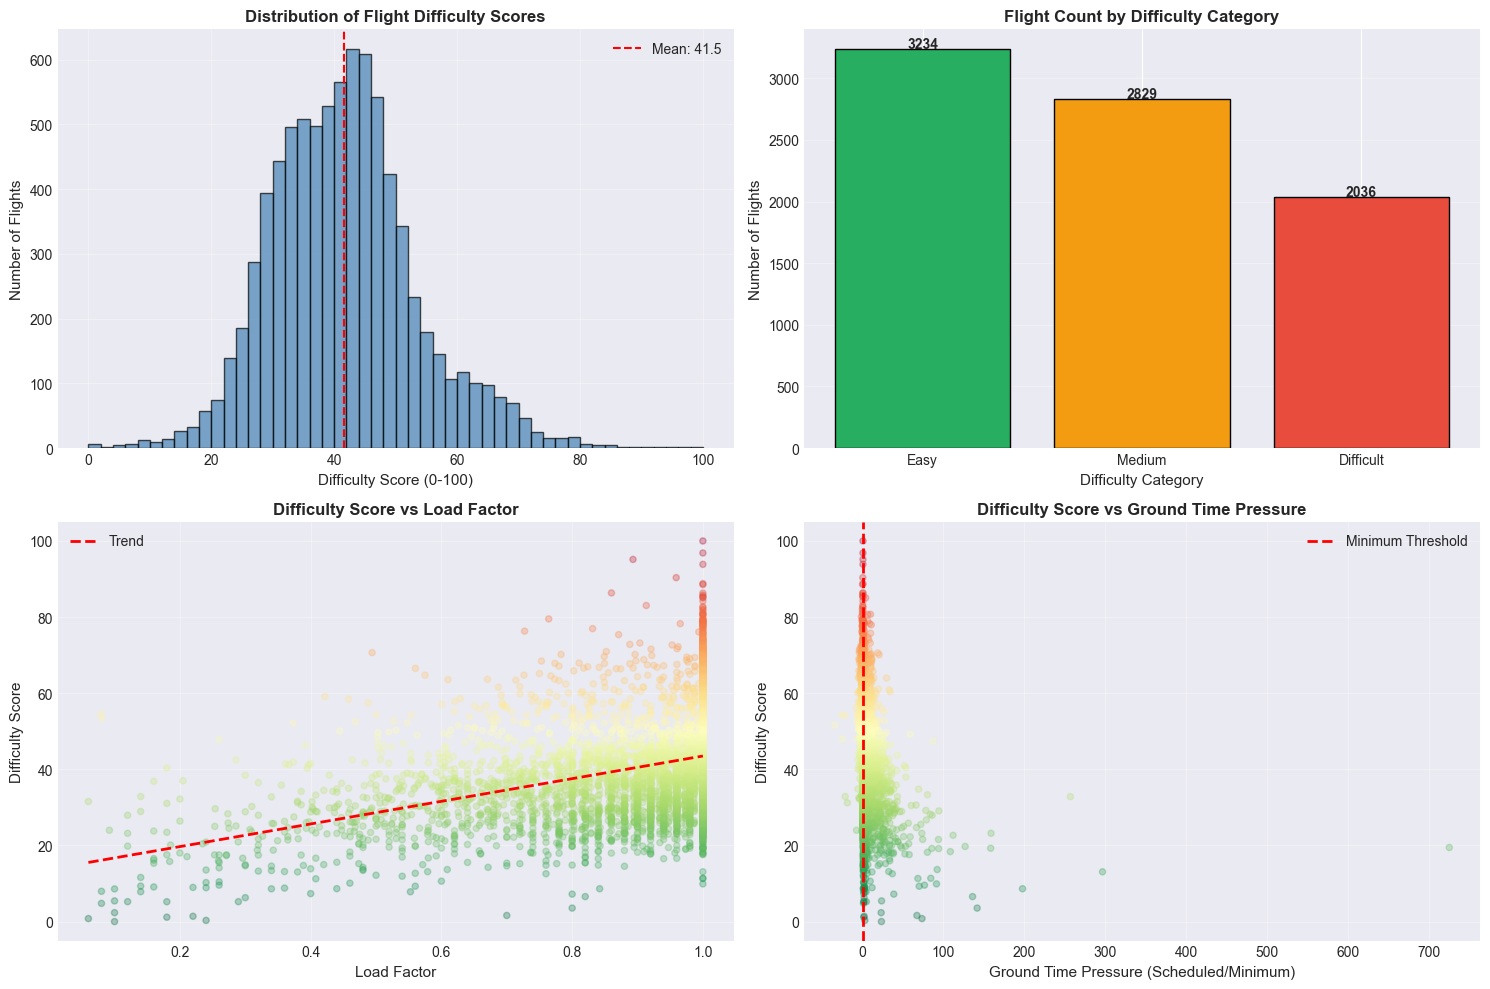

Overview visualizations created!


In [88]:
# Visualization 1 - Difficulty Score Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Overall difficulty score distribution
axes[0, 0].hist(master_data['difficulty_score_scaled'], bins=50, 
                color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Difficulty Score (0-100)', fontsize=11)
axes[0, 0].set_ylabel('Number of Flights', fontsize=11)
axes[0, 0].set_title('Distribution of Flight Difficulty Scores', fontsize=12, fontweight='bold')
axes[0, 0].axvline(master_data['difficulty_score_scaled'].mean(), 
                   color='red', linestyle='--', label=f"Mean: {master_data['difficulty_score_scaled'].mean():.1f}")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Difficulty by category
category_counts = master_data['difficulty_category'].value_counts()
colors = {'Difficult': '#e74c3c', 'Medium': '#f39c12', 'Easy': '#27ae60'}
axes[0, 1].bar(category_counts.index, category_counts.values,
               color=[colors[cat] for cat in category_counts.index], edgecolor='black')
axes[0, 1].set_xlabel('Difficulty Category', fontsize=11)
axes[0, 1].set_ylabel('Number of Flights', fontsize=11)
axes[0, 1].set_title('Flight Count by Difficulty Category', fontsize=12, fontweight='bold')
for i, v in enumerate(category_counts.values):
    axes[0, 1].text(i, v + 10, str(v), ha='center', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Difficulty score vs load factor
axes[1, 0].scatter(master_data['load_factor'], master_data['difficulty_score_scaled'],
                   alpha=0.3, s=20, c=master_data['difficulty_score_scaled'], cmap='RdYlGn_r')
axes[1, 0].set_xlabel('Load Factor', fontsize=11)
axes[1, 0].set_ylabel('Difficulty Score', fontsize=11)
axes[1, 0].set_title('Difficulty Score vs Load Factor', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Add trend line
z = np.polyfit(master_data['load_factor'].dropna(), 
               master_data.loc[master_data['load_factor'].notna(), 'difficulty_score_scaled'], 1)
p = np.poly1d(z)
axes[1, 0].plot(master_data['load_factor'].sort_values(), 
                p(master_data['load_factor'].sort_values()),
                "r--", linewidth=2, label='Trend')
axes[1, 0].legend()

# 4. Difficulty score vs ground time pressure
axes[1, 1].scatter(master_data['ground_time_pressure'], master_data['difficulty_score_scaled'],
                   alpha=0.3, s=20, c=master_data['difficulty_score_scaled'], cmap='RdYlGn_r')
axes[1, 1].set_xlabel('Ground Time Pressure (Scheduled/Minimum)', fontsize=11)
axes[1, 1].set_ylabel('Difficulty Score', fontsize=11)
axes[1, 1].set_title('Difficulty Score vs Ground Time Pressure', fontsize=12, fontweight='bold')
axes[1, 1].axvline(1.0, color='red', linestyle='--', label='Minimum Threshold', linewidth=2)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('difficulty_score_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("Overview visualizations created!")

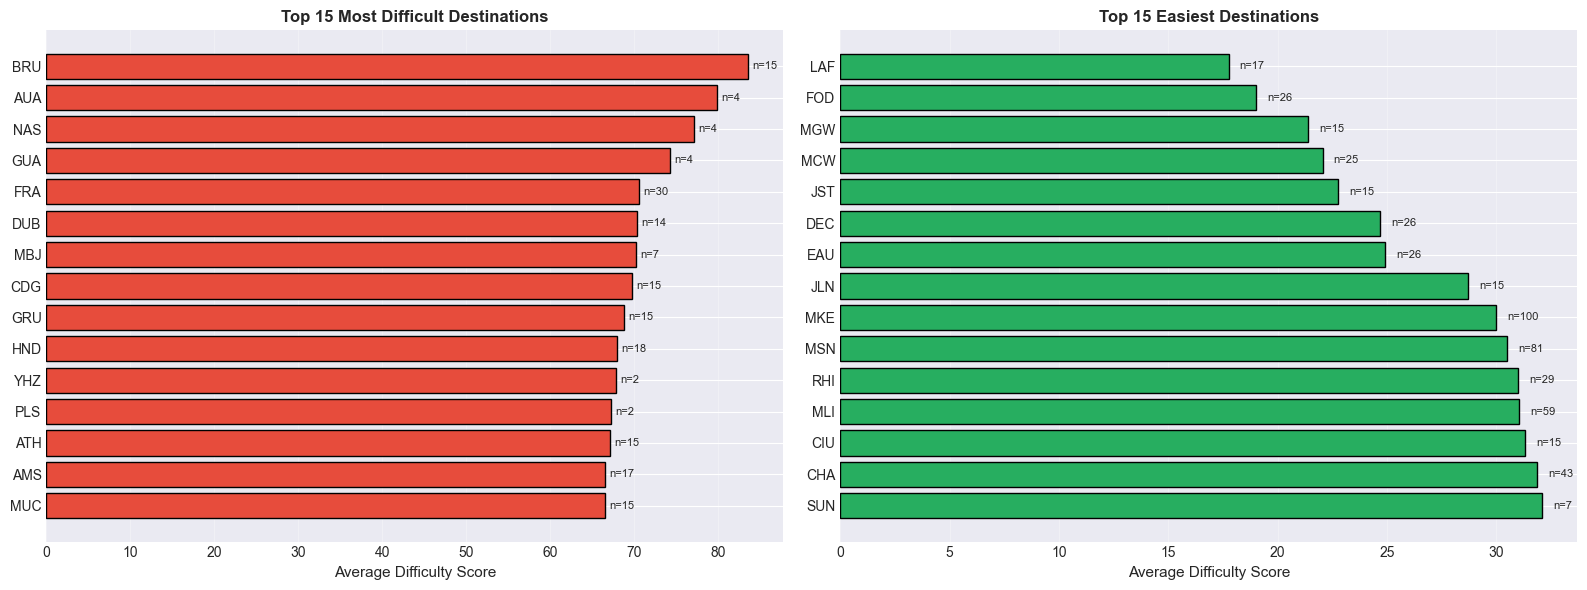

Destination visualizations created!


In [92]:
# Visualization 2 - Top Destinations by Difficulty
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 most difficult destinations
top_difficult = destination_analysis.head(15).sort_values('avg_difficulty')
axes[0].barh(range(len(top_difficult)), top_difficult['avg_difficulty'],
             color='#e74c3c', edgecolor='black')
axes[0].set_yticks(range(len(top_difficult)))
axes[0].set_yticklabels(top_difficult.index)
axes[0].set_xlabel('Average Difficulty Score', fontsize=11)
axes[0].set_title('Top 15 Most Difficult Destinations', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add flight count annotations
for i, (idx, row) in enumerate(top_difficult.iterrows()):
    axes[0].text(row['avg_difficulty'] + 0.5, i, 
                 f"n={int(row['flight_count'])}", 
                 va='center', fontsize=8)

# Bottom 15 easiest destinations
bottom_easy = destination_analysis.tail(15).sort_values('avg_difficulty', ascending=False)
axes[1].barh(range(len(bottom_easy)), bottom_easy['avg_difficulty'],
             color='#27ae60', edgecolor='black')
axes[1].set_yticks(range(len(bottom_easy)))
axes[1].set_yticklabels(bottom_easy.index)
axes[1].set_xlabel('Average Difficulty Score', fontsize=11)
axes[1].set_title('Top 15 Easiest Destinations', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add flight count annotations
for i, (idx, row) in enumerate(bottom_easy.iterrows()):
    axes[1].text(row['avg_difficulty'] + 0.5, i, 
                 f"n={int(row['flight_count'])}", 
                 va='center', fontsize=8)

plt.tight_layout()
plt.savefig('destinations_difficulty.png', dpi=300, bbox_inches='tight')
plt.show()

print("Destination visualizations created!")

In [ ]:
# Visualization 3 - Feature Importance

fig, ax = plt.subplots(figsize=(10, 8))

correlations_df_sorted = correlations_df.sort_values('Correlation')
colors = ['#27ae60' if x > 0 else '#e74c3c' for x in correlations_df_sorted['Correlation']]

ax.barh(range(len(correlations_df_sorted)), correlations_df_sorted['Correlation'],
        color=colors, edgecolor='black')
ax.set_yticks(range(len(correlations_df_sorted)))
ax.set_yticklabels(correlations_df_sorted['Feature'])
ax.set_xlabel('Correlation with Difficulty Score', fontsize=11)
ax.set_title('Feature Importance: Correlation with Difficulty Score', 
             fontsize=13, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add correlation values
for i, v in enumerate(correlations_df_sorted['Correlation']):
    ax.text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}', 
            va='center', ha='left' if v > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature importance visualization created!")

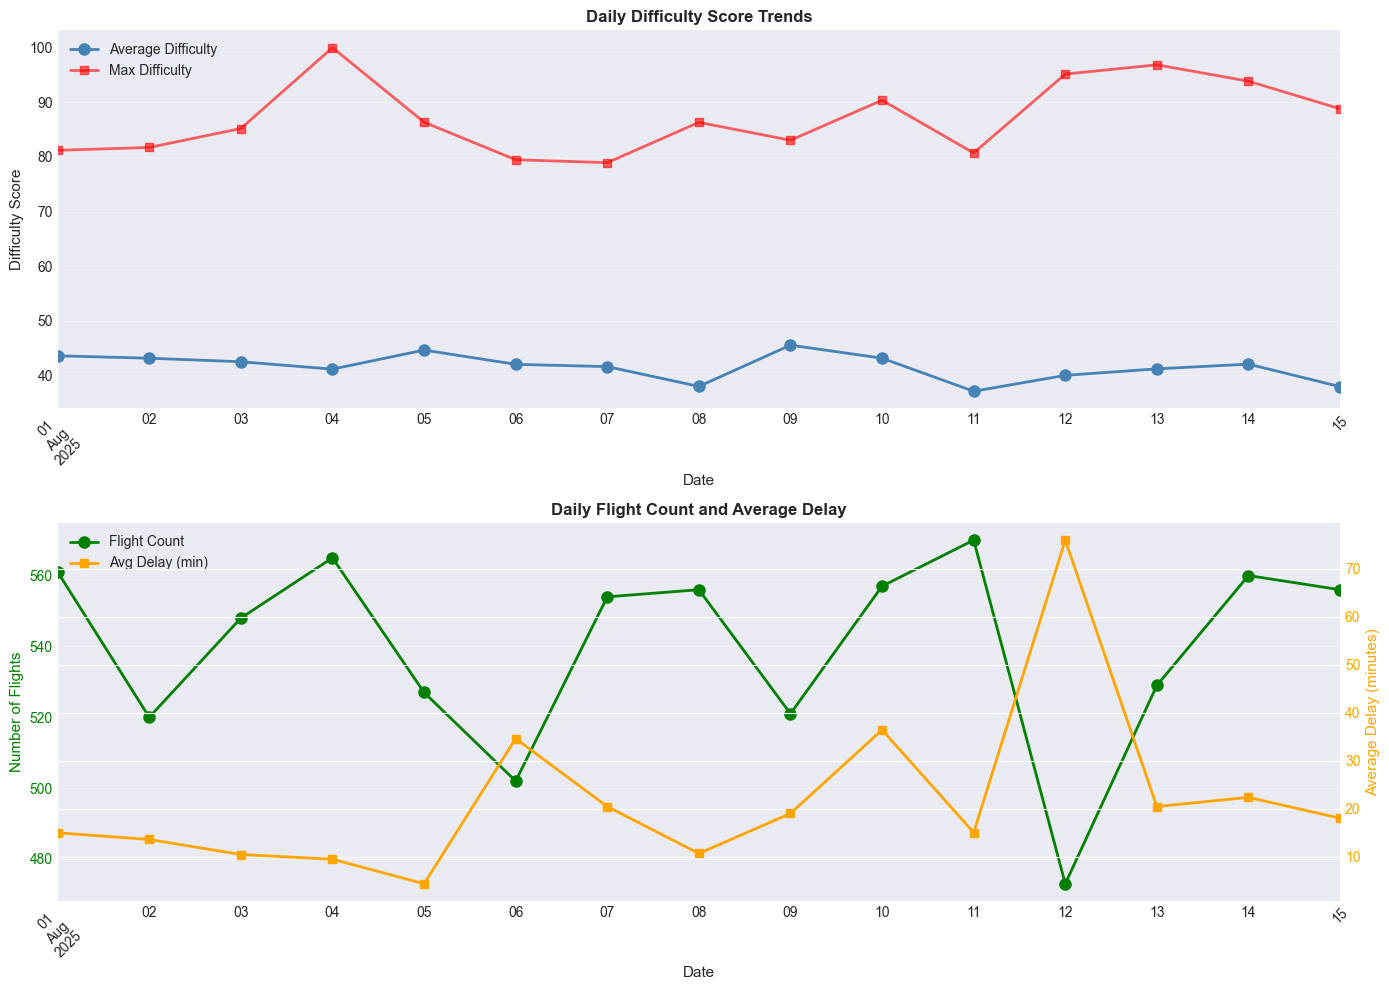

Daily trends visualization created!


In [94]:
# Visualization 4 - Daily Trends

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Daily difficulty trends
daily_stats.plot(y='avg_difficulty', ax=axes[0], marker='o', 
                 color='steelblue', linewidth=2, markersize=8, label='Average Difficulty')
daily_stats.plot(y='max_difficulty', ax=axes[0], marker='s', 
                 color='red', linewidth=2, markersize=6, alpha=0.6, label='Max Difficulty')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Difficulty Score', fontsize=11)
axes[0].set_title('Daily Difficulty Score Trends', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Daily flight count and delays
ax2 = axes[1]
daily_stats.plot(y='flight_count', ax=ax2, marker='o', 
                 color='green', linewidth=2, markersize=8, label='Flight Count')
ax2.set_ylabel('Number of Flights', fontsize=11, color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax3 = ax2.twinx()
daily_stats.plot(y='avg_delay', ax=ax3, marker='s', 
                 color='orange', linewidth=2, markersize=6, label='Avg Delay (min)')
ax3.set_ylabel('Average Delay (minutes)', fontsize=11, color='orange')
ax3.tick_params(axis='y', labelcolor='orange')

axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_title('Daily Flight Count and Average Delay', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax3.legend().set_visible(False)

plt.tight_layout()
plt.savefig('daily_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("Daily trends visualization created!")

In [95]:
# Output Dataset
output_columns = [
    # Identifiers
    'flight_id',
    'company_id',
    'flight_number',
    'scheduled_departure_date_local',
    'scheduled_departure_station_code',
    'scheduled_arrival_station_code',
    
    # Difficulty Score Components
    'difficulty_score',
    'difficulty_score_scaled',
    'daily_rank',
    'daily_percentile',
    'difficulty_category',
    
    # Key Features Used
    'ground_time_pressure',
    'is_tight_turnaround',
    'is_very_tight_turnaround',
    'load_factor',
    'bags_per_passenger',
    'transfer_ratio',
    'special_service_ratio',
    'wheelchair_ratio',
    'children_ratio',
    
    # Raw Counts
    'total_passengers',
    'total_bags',
    'checked_bags',
    'transfer_bags',
    'total_special_requests',
    'wheelchair_requests',
    'total_children',
    'total_lap_children',
    
    # Operational Metrics
    'scheduled_ground_time_minutes',
    'minimum_turn_minutes',
    'departure_delay_minutes',
    'fleet_type',
    'total_seats',
    'haul_type',
    'time_of_day',
    'is_international'
]

# Filter to available columns
available_output_cols = [col for col in output_columns if col in master_data.columns]
output_data = master_data[available_output_cols].copy()

# Sort by date and rank
output_data = output_data.sort_values(['scheduled_departure_date_local', 'daily_rank'])

print(f"Output dataset prepared with {len(output_data)} flights and {len(available_output_cols)} columns")
print("\nSample of output data:")
print(output_data.head(10))

Output dataset prepared with 8099 flights and 36 columns

Sample of output data:
                       flight_id company_id  flight_number  \
6578  UA_1811_2025-08-01_ORD_MSP         UA           1811   
6984   UA_972_2025-08-01_ORD_BRU         UA            972   
4110  UA_1146_2025-08-01_ORD_MBJ         UA           1146   
7382  UA_2011_2025-08-01_ORD_YVR         UA           2011   
6229   UA_907_2025-08-01_ORD_FRA         UA            907   
7180   UA_987_2025-08-01_ORD_CDG         UA            987   
5035   UA_970_2025-08-01_ORD_FCO         UA            970   
1174  UA_2090_2025-08-01_ORD_MIA         UA           2090   
2128  OO_5292_2025-08-01_ORD_MTY         OO           5292   
235    UA_845_2025-08-01_ORD_GRU         UA            845   

     scheduled_departure_date_local scheduled_departure_station_code  \
6578                     2025-08-01                              ORD   
6984                     2025-08-01                              ORD   
4110                

In [96]:
# Export to CSV
output_filename = 'team_sarthak.csv'
output_data.to_csv(output_filename, index=False)
print(f"\nResults exported to {output_filename}")

# generate summary statistics for report
print("\n" + "="*80)
print("SUMMARY STATISTICS FOR REPORT")
print("="*80)

print("\n1. OVERALL STATISTICS")
print(f"Total Flights Analyzed: {len(master_data):,}")
print(f"Date Range: {master_data['scheduled_departure_date_local'].min()} to {master_data['scheduled_departure_date_local'].max()}")
print(f"Unique Destinations: {master_data['scheduled_arrival_station_code'].nunique()}")
print(f"Average Difficulty Score: {master_data['difficulty_score_scaled'].mean():.2f}")
print(f"Median Difficulty Score: {master_data['difficulty_score_scaled'].median():.2f}")

print("\n2. DIFFICULTY CATEGORY BREAKDOWN")
category_breakdown = master_data['difficulty_category'].value_counts()
for category in ['Difficult', 'Medium', 'Easy']:
    count = category_breakdown.get(category, 0)
    pct = (count / len(master_data)) * 100
    print(f"{category}: {count:,} flights ({pct:.1f}%)")

print("\n3. DELAY STATISTICS")
print(f"Average Departure Delay: {master_data['departure_delay_minutes'].mean():.2f} minutes")
print(f"Flights with Delays > 0: {(master_data['departure_delay_minutes'] > 0).sum():,} ({(master_data['departure_delay_minutes'] > 0).sum()/len(master_data)*100:.1f}%)")
print(f"Flights with Delays > 15 min: {(master_data['departure_delay_minutes'] > 15).sum():,} ({(master_data['departure_delay_minutes'] > 15).sum()/len(master_data)*100:.1f}%)")

print("\n4. GROUND TIME CONSTRAINTS")
print(f"Flights with Tight Turnaround: {master_data['is_tight_turnaround'].sum():,} ({master_data['is_tight_turnaround'].sum()/len(master_data)*100:.1f}%)")
print(f"Flights with Very Tight Turnaround: {master_data['is_very_tight_turnaround'].sum():,} ({master_data['is_very_tight_turnaround'].sum()/len(master_data)*100:.1f}%)")
print(f"Average Ground Time Pressure: {master_data['ground_time_pressure'].mean():.2f}")

print("\n5. PASSENGER & SERVICE METRICS")
print(f"Average Load Factor: {master_data['load_factor'].mean():.2%}")
print(f"Average Passengers per Flight: {master_data['total_passengers'].mean():.1f}")
print(f"Average Special Service Requests per Flight: {master_data['total_special_requests'].mean():.2f}")
print(f"Flights with Children: {(master_data['total_children'] > 0).sum():,} ({(master_data['total_children'] > 0).sum()/len(master_data)*100:.1f}%)")

print("\n6. BAGGAGE METRICS")
print(f"Average Bags per Flight: {master_data['total_bags'].mean():.1f}")
print(f"Average Bags per Passenger: {master_data['bags_per_passenger'].mean():.2f}")
print(f"Average Transfer Bag Ratio: {master_data['transfer_ratio'].mean():.2%}")

print("\n7. TOP 10 MOST DIFFICULT DESTINATIONS")
top_10_difficult = destination_analysis.head(10)
for idx, row in top_10_difficult.iterrows():
    print(f"{idx}: Difficulty={row['avg_difficulty']:.1f}, Flights={int(row['flight_count'])}, Delay={row['avg_delay']:.1f}min")

print("\n8. KEY DIFFICULTY DRIVERS (Top 5 Correlations)")
for idx, row in correlations_df.head(5).iterrows():
    print(f"{row['Feature']}: {row['Correlation']:.3f}")

# generate operational recommendations
print("\n" + "="*80)
print("OPERATIONAL RECOMMENDATIONS")
print("="*80)

# Identify high-risk combinations
high_risk_flights = master_data[
    (master_data['difficulty_category'] == 'Difficult') &
    (master_data['is_tight_turnaround'] == 1) &
    (master_data['load_factor'] > 0.85)
]

print(f"\n1. HIGH-RISK FLIGHTS REQUIRING IMMEDIATE ATTENTION")
print(f"   {len(high_risk_flights)} flights have combination of:")
print(f"   - High difficulty score (top 25%)")
print(f"   - Tight turnaround time")
print(f"   - High load factor (>85%)")
print(f"   Recommendation: Pre-assign additional ground crew and expedite boarding")

# Identify high special service flights
high_service_flights = master_data[master_data['special_service_ratio'] > master_data['special_service_ratio'].quantile(0.90)]
print(f"\n2. HIGH SPECIAL SERVICE DEMAND")
print(f"   {len(high_service_flights)} flights have exceptionally high special service requests")
print(f"   Recommendation: Ensure wheelchair/mobility assistance teams are pre-positioned")

# Identify baggage-heavy flights
high_bag_flights = master_data[master_data['bags_per_passenger'] > master_data['bags_per_passenger'].quantile(0.90)]
print(f"\n3. BAGGAGE-HEAVY OPERATIONS")
print(f"   {len(high_bag_flights)} flights have high bags-per-passenger ratio")
print(f"   Recommendation: Allocate additional baggage handlers and loading equipment")

# Peak time analysis
peak_difficult = master_data[
    (master_data['time_of_day'].isin(['Morning_Peak', 'Evening_Peak'])) &
    (master_data['difficulty_category'] == 'Difficult')
]
print(f"\n4. PEAK TIME OPERATIONS")
print(f"   {len(peak_difficult)} difficult flights operate during peak hours")
print(f"   Recommendation: Implement staggered staffing with peak-hour surge capacity")

print("\n" + "="*80)


Results exported to team_sarthak.csv

SUMMARY STATISTICS FOR REPORT

1. OVERALL STATISTICS
Total Flights Analyzed: 8,099
Date Range: 2025-08-01 00:00:00 to 2025-08-15 00:00:00
Unique Destinations: 188
Average Difficulty Score: 41.55
Median Difficulty Score: 41.19

2. DIFFICULTY CATEGORY BREAKDOWN
Difficult: 2,036 flights (25.1%)
Medium: 2,829 flights (34.9%)
Easy: 3,234 flights (39.9%)

3. DELAY STATISTICS
Average Departure Delay: 21.18 minutes
Flights with Delays > 0: 4,018 (49.6%)
Flights with Delays > 15 min: 2,163 (26.7%)

4. GROUND TIME CONSTRAINTS
Flights with Tight Turnaround: 780 (9.6%)
Flights with Very Tight Turnaround: 652 (8.1%)
Average Ground Time Pressure: 3.96

5. PASSENGER & SERVICE METRICS
Average Load Factor: 93.45%
Average Passengers per Flight: 128.5
Average Special Service Requests per Flight: 2.25
Flights with Children: 7,085 (87.5%)

6. BAGGAGE METRICS
Average Bags per Flight: 78.3
Average Bags per Passenger: 0.65
Average Transfer Bag Ratio: 299.65%

7. TOP 10 M

EDA QUESTION 1: Average Delay and Late Departure Percentage

Average Departure Delay: 21.18 minutes
Median Departure Delay: 0.00 minutes
Flights Departing Late (>0 min): 4,018 out of 8,099
Percentage of Late Departures: 49.61%

Delayed by more than 15 minutes: 2,163 (26.71%)
Delayed by more than 30 minutes: 1,528 (18.87%)
Delayed by more than 60 minutes: 935 (11.54%)


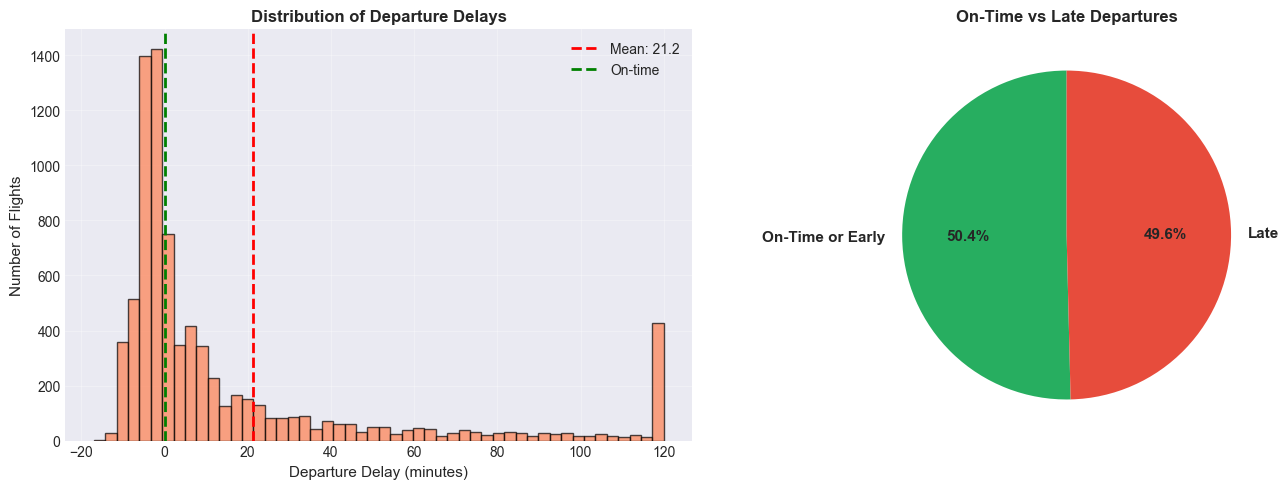

In [97]:
# EDA Question 1 - Average Delay and Late Departures

print("="*80)
print("EDA QUESTION 1: Average Delay and Late Departure Percentage")
print("="*80)

avg_delay = master_data['departure_delay_minutes'].mean()
median_delay = master_data['departure_delay_minutes'].median()
late_departures = (master_data['departure_delay_minutes'] > 0).sum()
late_pct = (late_departures / len(master_data)) * 100

print(f"\nAverage Departure Delay: {avg_delay:.2f} minutes")
print(f"Median Departure Delay: {median_delay:.2f} minutes")
print(f"Flights Departing Late (>0 min): {late_departures:,} out of {len(master_data):,}")
print(f"Percentage of Late Departures: {late_pct:.2f}%")

# Additional delay analysis
delay_15 = (master_data['departure_delay_minutes'] > 15).sum()
delay_30 = (master_data['departure_delay_minutes'] > 30).sum()
delay_60 = (master_data['departure_delay_minutes'] > 60).sum()

print(f"\nDelayed by more than 15 minutes: {delay_15:,} ({delay_15/len(master_data)*100:.2f}%)")
print(f"Delayed by more than 30 minutes: {delay_30:,} ({delay_30/len(master_data)*100:.2f}%)")
print(f"Delayed by more than 60 minutes: {delay_60:,} ({delay_60/len(master_data)*100:.2f}%)")

# Visualize delay distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of delays (capped at 120 for visibility)
delay_capped = master_data['departure_delay_minutes'].clip(upper=120)
axes[0].hist(delay_capped, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].axvline(avg_delay, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_delay:.1f}')
axes[0].axvline(0, color='green', linestyle='--', linewidth=2, label='On-time')
axes[0].set_xlabel('Departure Delay (minutes)', fontsize=11)
axes[0].set_ylabel('Number of Flights', fontsize=11)
axes[0].set_title('Distribution of Departure Delays', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Pie chart of on-time vs late
on_time = len(master_data) - late_departures
labels = ['On-Time or Early', 'Late']
sizes = [on_time, late_departures]
colors = ['#27ae60', '#e74c3c']
axes[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('On-Time vs Late Departures', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_delays.png', dpi=300, bbox_inches='tight')
plt.show()


EDA QUESTION 2: Flights with Ground Time Close to/Below Minimum

Flights with Ground Time <= Minimum: 652 (8.05%)
Flights with Ground Time within 110% of Minimum: 128 (1.58%)
Total At-Risk Flights: 780 (9.63%)

Average Ground Time Pressure Ratio: 3.96
  (Ratio = Scheduled Ground Time / Minimum Turn Time)
  Ratio < 1.0 means insufficient time
  Ratio = 1.0 means exactly minimum time
  Ratio > 1.0 means buffer time available

Flights with Insufficient Ground Time (ratio < 1.0): 630


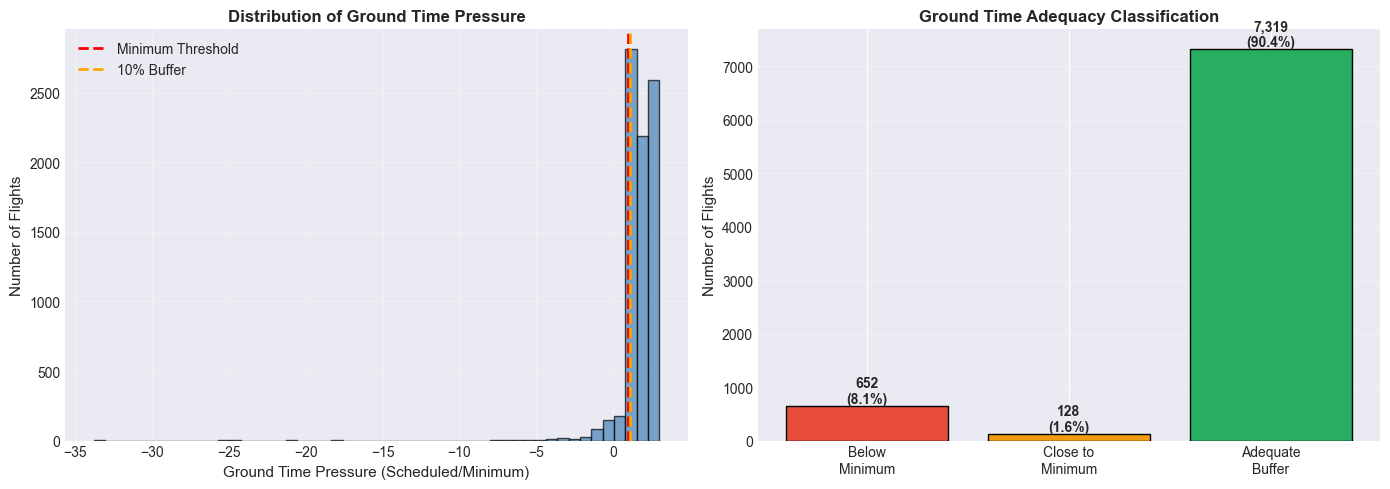

In [98]:
# EDA Question 2 - Ground Time Analysis
print("\n" + "="*80)
print("EDA QUESTION 2: Flights with Ground Time Close to/Below Minimum")
print("="*80)

# Calculate how many flights have ground time <= minimum
below_minimum = (master_data['scheduled_ground_time_minutes'] <= master_data['minimum_turn_minutes']).sum()
below_minimum_pct = (below_minimum / len(master_data)) * 100

# Close to minimum (within 10% buffer)
close_to_minimum = (
    (master_data['scheduled_ground_time_minutes'] > master_data['minimum_turn_minutes']) &
    (master_data['scheduled_ground_time_minutes'] <= master_data['minimum_turn_minutes'] * 1.1)
).sum()
close_to_minimum_pct = (close_to_minimum / len(master_data)) * 100

# Total at-risk
at_risk = below_minimum + close_to_minimum
at_risk_pct = (at_risk / len(master_data)) * 100

print(f"\nFlights with Ground Time <= Minimum: {below_minimum:,} ({below_minimum_pct:.2f}%)")
print(f"Flights with Ground Time within 110% of Minimum: {close_to_minimum:,} ({close_to_minimum_pct:.2f}%)")
print(f"Total At-Risk Flights: {at_risk:,} ({at_risk_pct:.2f}%)")

# Ground time statistics
print(f"\nAverage Ground Time Pressure Ratio: {master_data['ground_time_pressure'].mean():.2f}")
print(f"  (Ratio = Scheduled Ground Time / Minimum Turn Time)")
print(f"  Ratio < 1.0 means insufficient time")
print(f"  Ratio = 1.0 means exactly minimum time")
print(f"  Ratio > 1.0 means buffer time available")

insufficient_time = (master_data['ground_time_pressure'] < 1.0).sum()
print(f"\nFlights with Insufficient Ground Time (ratio < 1.0): {insufficient_time:,}")

# Visualize ground time pressure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of ground time pressure
ground_time_capped = master_data['ground_time_pressure'].clip(upper=3)
axes[0].hist(ground_time_capped, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Minimum Threshold')
axes[0].axvline(1.1, color='orange', linestyle='--', linewidth=2, label='10% Buffer')
axes[0].set_xlabel('Ground Time Pressure (Scheduled/Minimum)', fontsize=11)
axes[0].set_ylabel('Number of Flights', fontsize=11)
axes[0].set_title('Distribution of Ground Time Pressure', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Stacked bar chart
categories = ['Below\nMinimum', 'Close to\nMinimum', 'Adequate\nBuffer']
values = [below_minimum, close_to_minimum, len(master_data) - at_risk]
colors_bar = ['#e74c3c', '#f39c12', '#27ae60']
axes[1].bar(categories, values, color=colors_bar, edgecolor='black')
axes[1].set_ylabel('Number of Flights', fontsize=11)
axes[1].set_title('Ground Time Adequacy Classification', fontsize=12, fontweight='bold')
for i, v in enumerate(values):
    pct = (v / len(master_data)) * 100
    axes[1].text(i, v + 50, f'{v:,}\n({pct:.1f}%)', 
                ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_ground_time.png', dpi=300, bbox_inches='tight')
plt.show()


EDA QUESTION 3: Transfer Bags vs Checked Bags Ratio

Average Transfer Bag Ratio: 299.65%
Median Transfer Bag Ratio: 130.00%

No Transfer Bags (0%): 27 flights (0.3%)
Low Transfer (0-25%): 664 flights (8.2%)
Medium Transfer (25-50%): 928 flights (11.5%)
High Transfer (>50%): 6,480 flights (80.0%)

Average Checked Bags per Flight: 34.6
Average Transfer Bags per Flight: 38.0
Average Total Bags per Flight: 78.3


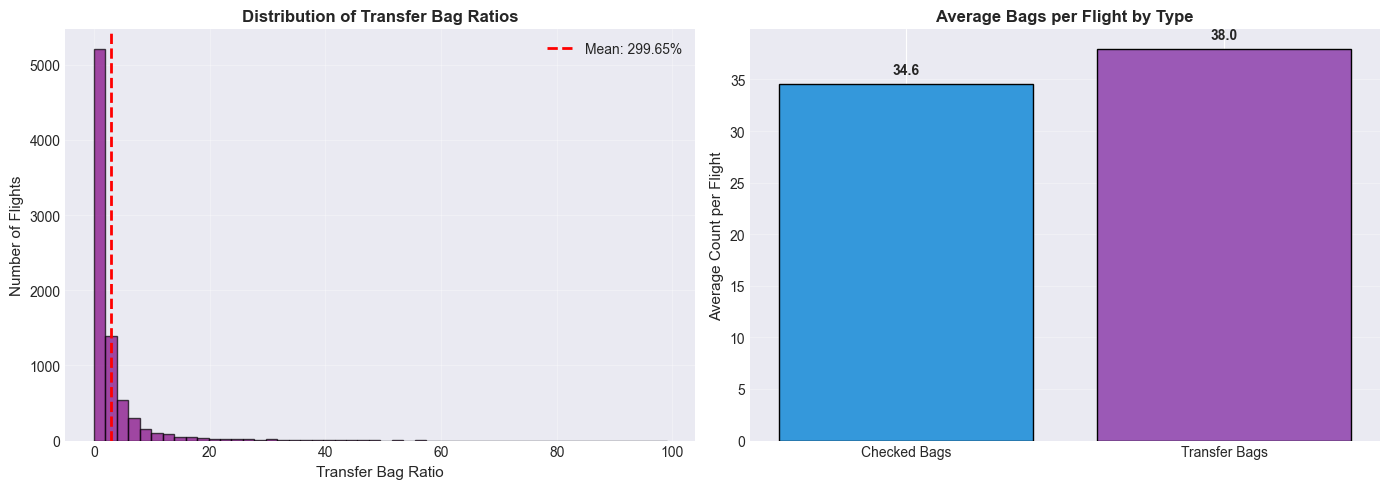

In [100]:
# EDA Question 3 - Transfer Bags Ratio
print("\n" + "="*80)
print("EDA QUESTION 3: Transfer Bags vs Checked Bags Ratio")
print("="*80)

avg_transfer_ratio = master_data['transfer_ratio'].mean()
median_transfer_ratio = master_data['transfer_ratio'].median()

print(f"\nAverage Transfer Bag Ratio: {avg_transfer_ratio:.2%}")
print(f"Median Transfer Bag Ratio: {median_transfer_ratio:.2%}")

# Breakdown by categories
no_transfer = (master_data['transfer_ratio'] == 0).sum()
low_transfer = ((master_data['transfer_ratio'] > 0) & (master_data['transfer_ratio'] <= 0.25)).sum()
med_transfer = ((master_data['transfer_ratio'] > 0.25) & (master_data['transfer_ratio'] <= 0.5)).sum()
high_transfer = (master_data['transfer_ratio'] > 0.5).sum()

print(f"\nNo Transfer Bags (0%): {no_transfer:,} flights ({no_transfer/len(master_data)*100:.1f}%)")
print(f"Low Transfer (0-25%): {low_transfer:,} flights ({low_transfer/len(master_data)*100:.1f}%)")
print(f"Medium Transfer (25-50%): {med_transfer:,} flights ({med_transfer/len(master_data)*100:.1f}%)")
print(f"High Transfer (>50%): {high_transfer:,} flights ({high_transfer/len(master_data)*100:.1f}%)")

# Average counts
print(f"\nAverage Checked Bags per Flight: {master_data['checked_bags'].mean():.1f}")
print(f"Average Transfer Bags per Flight: {master_data['transfer_bags'].mean():.1f}")
print(f"Average Total Bags per Flight: {master_data['total_bags'].mean():.1f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of transfer ratios
axes[0].hist(master_data['transfer_ratio'], bins=50, color='purple', 
             edgecolor='black', alpha=0.7)
axes[0].axvline(avg_transfer_ratio, color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {avg_transfer_ratio:.2%}')
axes[0].set_xlabel('Transfer Bag Ratio', fontsize=11)
axes[0].set_ylabel('Number of Flights', fontsize=11)
axes[0].set_title('Distribution of Transfer Bag Ratios', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Stacked comparison of bag types
bag_type_data = master_data[['checked_bags', 'transfer_bags']].mean()
axes[1].bar(['Checked Bags', 'Transfer Bags'], bag_type_data.values,
           color=['#3498db', '#9b59b6'], edgecolor='black')
axes[1].set_ylabel('Average Count per Flight', fontsize=11)
axes[1].set_title('Average Bags per Flight by Type', fontsize=12, fontweight='bold')
for i, v in enumerate(bag_type_data.values):
    axes[1].text(i, v + 1, f'{v:.1f}', ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_bags.png', dpi=300, bbox_inches='tight')
plt.show()


EDA QUESTION 4: Passenger Load Comparison and Correlation with Difficulty

Average Load Factor: 93.45%
Median Load Factor: 100.00%

Low Load (<60%): 349 flights (4.3%)
Medium Load (60-85%): 878 flights (10.8%)
High Load (≥85%): 6,872 flights (84.8%)

Correlation between Load Factor and Difficulty Score: 0.350
Correlation between Load Factor and Departure Delay: -0.166

Average Difficulty Score by Load Category:
  Low: 27.61
  Medium: 36.48
  High: 42.92

Average Delay by Load Category:
  Low: 57.93 minutes
  Medium: 41.26 minutes
  High: 16.73 minutes


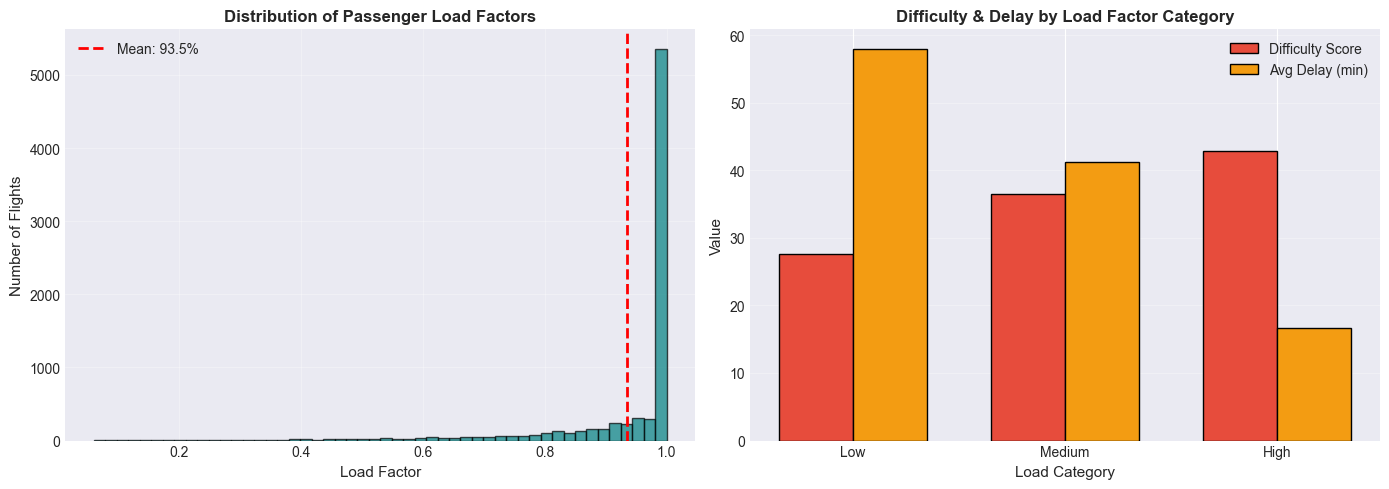

In [101]:
# EDA Question 4 - Passenger Load Analysis
print("\n" + "="*80)
print("EDA QUESTION 4: Passenger Load Comparison and Correlation with Difficulty")
print("="*80)

avg_load_factor = master_data['load_factor'].mean()
median_load_factor = master_data['load_factor'].median()

print(f"\nAverage Load Factor: {avg_load_factor:.2%}")
print(f"Median Load Factor: {median_load_factor:.2%}")

# Load factor categories
low_load = (master_data['load_factor'] < 0.6).sum()
med_load = ((master_data['load_factor'] >= 0.6) & (master_data['load_factor'] < 0.85)).sum()
high_load = (master_data['load_factor'] >= 0.85).sum()

print(f"\nLow Load (<60%): {low_load:,} flights ({low_load/len(master_data)*100:.1f}%)")
print(f"Medium Load (60-85%): {med_load:,} flights ({med_load/len(master_data)*100:.1f}%)")
print(f"High Load (≥85%): {high_load:,} flights ({high_load/len(master_data)*100:.1f}%)")

# Correlation with operational difficulty
load_difficulty_corr = master_data[['load_factor', 'difficulty_score']].corr().iloc[0, 1]
load_delay_corr = master_data[['load_factor', 'departure_delay_minutes']].corr().iloc[0, 1]

print(f"\nCorrelation between Load Factor and Difficulty Score: {load_difficulty_corr:.3f}")
print(f"Correlation between Load Factor and Departure Delay: {load_delay_corr:.3f}")

# Compare difficulty by load category
master_data['load_category'] = pd.cut(master_data['load_factor'], 
                                      bins=[0, 0.6, 0.85, 1.0],
                                      labels=['Low', 'Medium', 'High'])

difficulty_by_load = master_data.groupby('load_category')['difficulty_score_scaled'].mean()
delay_by_load = master_data.groupby('load_category')['departure_delay_minutes'].mean()

print(f"\nAverage Difficulty Score by Load Category:")
for cat in ['Low', 'Medium', 'High']:
    print(f"  {cat}: {difficulty_by_load[cat]:.2f}")

print(f"\nAverage Delay by Load Category:")
for cat in ['Low', 'Medium', 'High']:
    print(f"  {cat}: {delay_by_load[cat]:.2f} minutes")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Load factor distribution
axes[0].hist(master_data['load_factor'], bins=50, color='teal', 
            edgecolor='black', alpha=0.7)
axes[0].axvline(avg_load_factor, color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {avg_load_factor:.1%}')
axes[0].set_xlabel('Load Factor', fontsize=11)
axes[0].set_ylabel('Number of Flights', fontsize=11)
axes[0].set_title('Distribution of Passenger Load Factors', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Difficulty by load category
x_pos = np.arange(len(difficulty_by_load))
width = 0.35
axes[1].bar(x_pos - width/2, difficulty_by_load.values, width, 
           label='Difficulty Score', color='#e74c3c', edgecolor='black')
axes[1].bar(x_pos + width/2, delay_by_load.values, width, 
           label='Avg Delay (min)', color='#f39c12', edgecolor='black')
axes[1].set_xlabel('Load Category', fontsize=11)
axes[1].set_ylabel('Value', fontsize=11)
axes[1].set_title('Difficulty & Delay by Load Factor Category', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(difficulty_by_load.index)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_load_factor.png', dpi=300, bbox_inches='tight')
plt.show()



EDA QUESTION 5: High Special Service Requests vs Delays (Controlling for Load)

High Special Service Request Threshold: 0.026
Flights with High SSR: 2,025

Comparison of High SSR vs Normal SSR (Controlling for Load Factor):
Load Category  High SSR Delay  Normal SSR Delay  Delay Difference  High SSR Difficulty  Normal SSR Difficulty  Difficulty Difference
         <60%       98.345794         40.837945         57.507850            32.860564              25.384954               7.475611
       60-75%       56.377778         34.379592         21.998186            37.151117              35.711141               1.439976
       75-85%       58.039370         34.344444         23.694926            42.530074              34.619242               7.910832
         ≥85%       17.574275         16.458972          1.115303            45.552851              42.080150               3.472701

Overall Average Delay:
  High SSR Flights: 26.97 minutes
  Normal SSR Flights: 19.26 minutes
  Difference: 7.

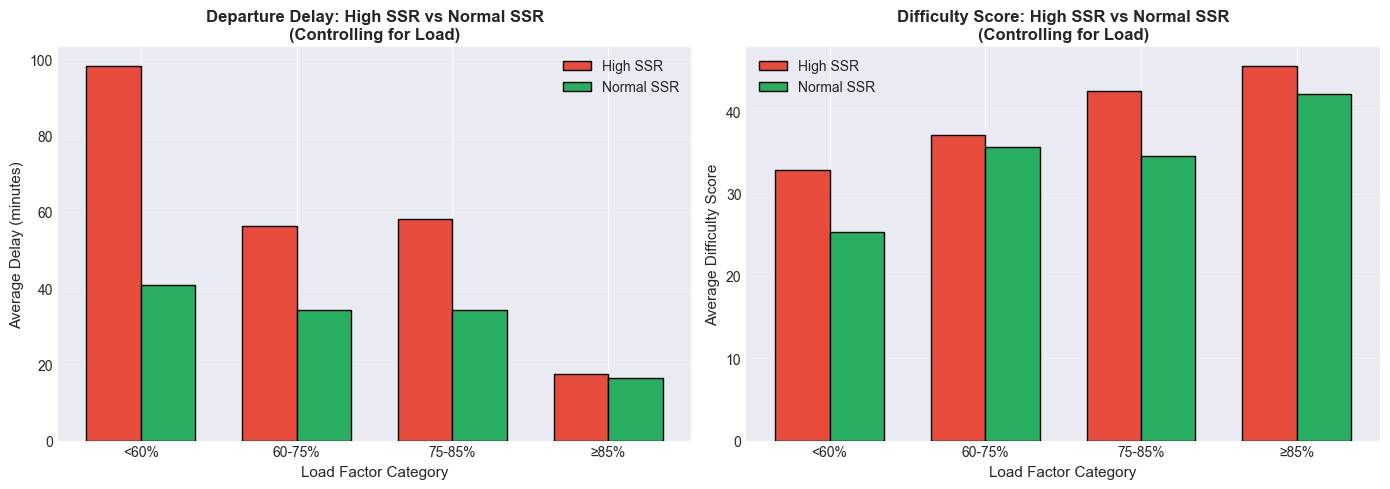


EDA ANALYSIS COMPLETE!


In [102]:

# EDA Question 5 - High Special Service vs High Delay (Controlling for Load)
print("\n" + "="*80)
print("EDA QUESTION 5: High Special Service Requests vs Delays (Controlling for Load)")
print("="*80)

# Define high special service threshold (top 25%)
high_ssr_threshold = master_data['special_service_ratio'].quantile(0.75)
master_data['is_high_ssr'] = (master_data['special_service_ratio'] > high_ssr_threshold).astype(int)

print(f"\nHigh Special Service Request Threshold: {high_ssr_threshold:.3f}")
print(f"Flights with High SSR: {master_data['is_high_ssr'].sum():,}")

# Compare delays for high SSR vs normal SSR, controlling for load
# We'll look at different load factor bins
load_bins = [0, 0.6, 0.75, 0.85, 1.0]
load_labels = ['<60%', '60-75%', '75-85%', '≥85%']
master_data['load_bin'] = pd.cut(master_data['load_factor'], bins=load_bins, labels=load_labels)

comparison_results = []
for load_cat in load_labels:
    load_subset = master_data[master_data['load_bin'] == load_cat]
    
    high_ssr_delay = load_subset[load_subset['is_high_ssr'] == 1]['departure_delay_minutes'].mean()
    normal_ssr_delay = load_subset[load_subset['is_high_ssr'] == 0]['departure_delay_minutes'].mean()
    
    high_ssr_difficulty = load_subset[load_subset['is_high_ssr'] == 1]['difficulty_score_scaled'].mean()
    normal_ssr_difficulty = load_subset[load_subset['is_high_ssr'] == 0]['difficulty_score_scaled'].mean()
    
    comparison_results.append({
        'Load Category': load_cat,
        'High SSR Delay': high_ssr_delay,
        'Normal SSR Delay': normal_ssr_delay,
        'Delay Difference': high_ssr_delay - normal_ssr_delay,
        'High SSR Difficulty': high_ssr_difficulty,
        'Normal SSR Difficulty': normal_ssr_difficulty,
        'Difficulty Difference': high_ssr_difficulty - normal_ssr_difficulty
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nComparison of High SSR vs Normal SSR (Controlling for Load Factor):")
print(comparison_df.to_string(index=False))

# Overall comparison
overall_high_ssr_delay = master_data[master_data['is_high_ssr'] == 1]['departure_delay_minutes'].mean()
overall_normal_ssr_delay = master_data[master_data['is_high_ssr'] == 0]['departure_delay_minutes'].mean()

print(f"\nOverall Average Delay:")
print(f"  High SSR Flights: {overall_high_ssr_delay:.2f} minutes")
print(f"  Normal SSR Flights: {overall_normal_ssr_delay:.2f} minutes")
print(f"  Difference: {overall_high_ssr_delay - overall_normal_ssr_delay:.2f} minutes")

# Statistical insight
print(f"\nConclusion:")
if overall_high_ssr_delay > overall_normal_ssr_delay:
    print(f"  High special service flights have {overall_high_ssr_delay - overall_normal_ssr_delay:.2f} minutes")
    print(f"  more delay on average, even after controlling for passenger load.")
else:
    print(f"  High special service flights do not show significantly higher delays")
    print(f"  when controlling for passenger load.")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Delay comparison across load categories
x = np.arange(len(load_labels))
width = 0.35
axes[0].bar(x - width/2, comparison_df['High SSR Delay'], width,
           label='High SSR', color='#e74c3c', edgecolor='black')
axes[0].bar(x + width/2, comparison_df['Normal SSR Delay'], width,
           label='Normal SSR', color='#27ae60', edgecolor='black')
axes[0].set_xlabel('Load Factor Category', fontsize=11)
axes[0].set_ylabel('Average Delay (minutes)', fontsize=11)
axes[0].set_title('Departure Delay: High SSR vs Normal SSR\n(Controlling for Load)', 
                 fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(load_labels)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Difficulty comparison across load categories
axes[1].bar(x - width/2, comparison_df['High SSR Difficulty'], width,
           label='High SSR', color='#e74c3c', edgecolor='black')
axes[1].bar(x + width/2, comparison_df['Normal SSR Difficulty'], width,
           label='Normal SSR', color='#27ae60', edgecolor='black')
axes[1].set_xlabel('Load Factor Category', fontsize=11)
axes[1].set_ylabel('Average Difficulty Score', fontsize=11)
axes[1].set_title('Difficulty Score: High SSR vs Normal SSR\n(Controlling for Load)', 
                 fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(load_labels)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_special_service.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("EDA ANALYSIS COMPLETE!")
print("="*80)

Creating advanced visualizations...


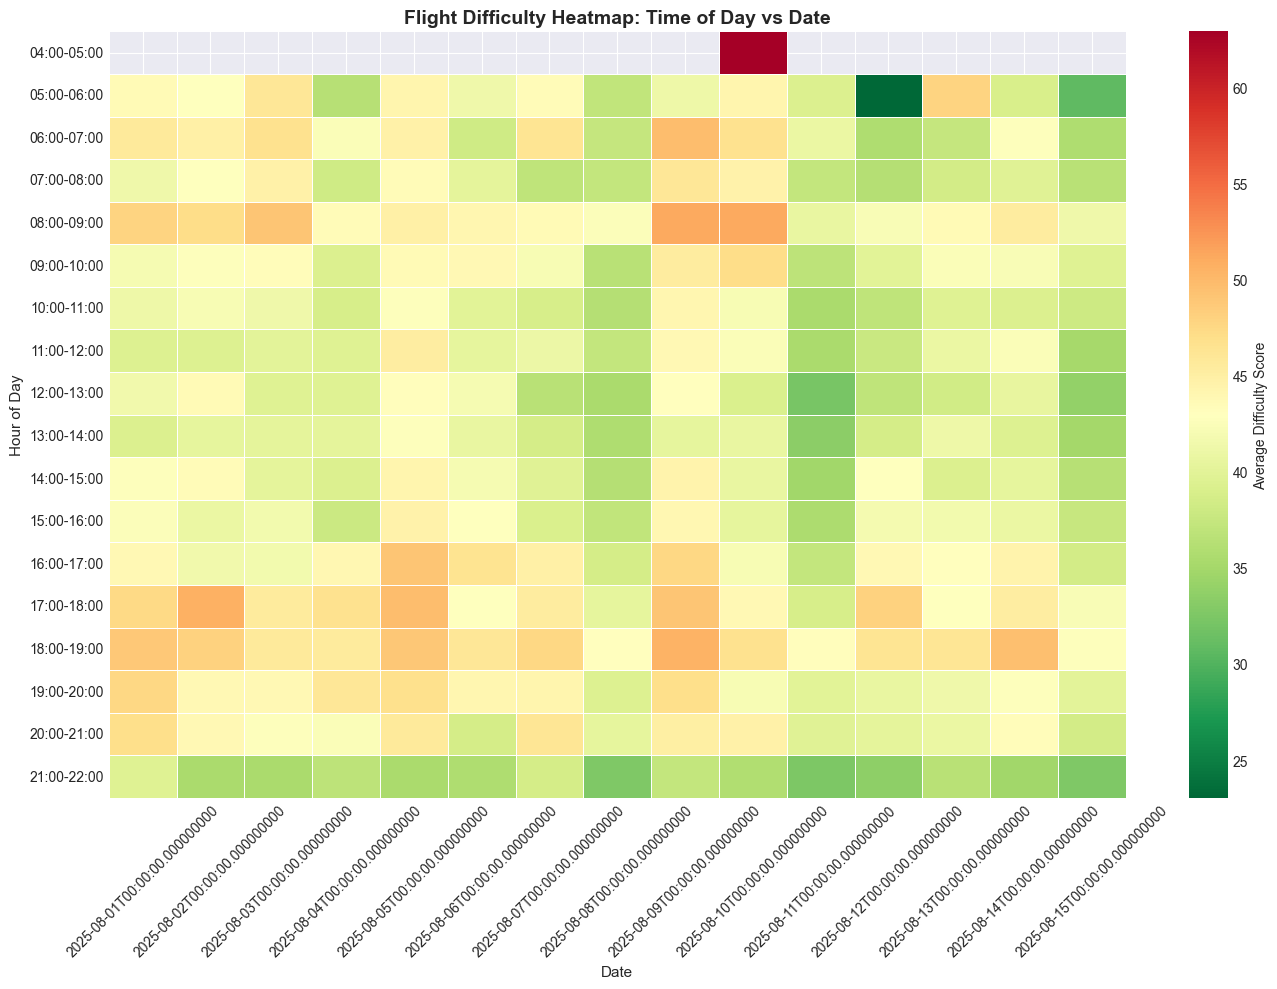

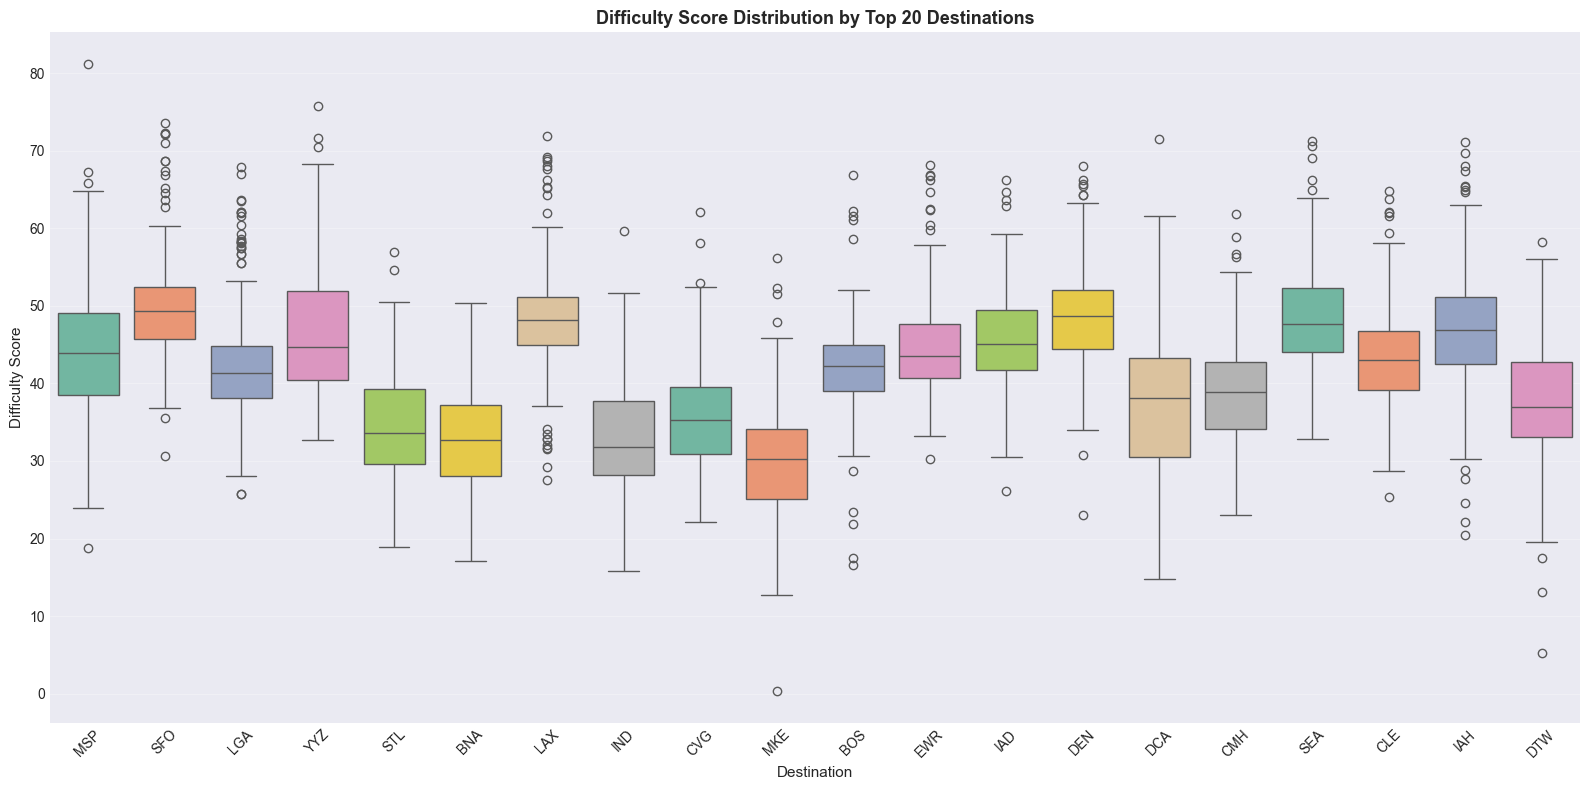

In [103]:
# Heatmap of Difficulty by Day and Hour
print("Creating advanced visualizations...")

# Create hour of day bins
master_data['hour_bin'] = master_data['departure_hour'].apply(
    lambda x: f"{int(x):02d}:00-{int(x)+1:02d}:00"
)

# Pivot table for heatmap
heatmap_data = master_data.pivot_table(
    values='difficulty_score_scaled',
    index='hour_bin',
    columns='scheduled_departure_date_local',
    aggfunc='mean'
)

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='RdYlGn_r', annot=False, fmt='.1f', 
            cbar_kws={'label': 'Average Difficulty Score'},
            linewidths=0.5)
plt.title('Flight Difficulty Heatmap: Time of Day vs Date', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=11)
plt.ylabel('Hour of Day', fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('difficulty_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Box Plot - Difficulty by Destination (Top 20)
top_20_destinations = master_data['scheduled_arrival_station_code'].value_counts().head(20).index
top_20_data = master_data[master_data['scheduled_arrival_station_code'].isin(top_20_destinations)]

plt.figure(figsize=(16, 8))
sns.boxplot(data=top_20_data, x='scheduled_arrival_station_code', y='difficulty_score_scaled',
            palette='Set2')
plt.xticks(rotation=45)
plt.xlabel('Destination', fontsize=11)
plt.ylabel('Difficulty Score', fontsize=11)
plt.title('Difficulty Score Distribution by Top 20 Destinations', fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('difficulty_by_destination_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Scatter Matrix - Key Features

key_features_for_scatter = [
    'difficulty_score_scaled', 'load_factor', 'bags_per_passenger',
    'ground_time_pressure', 'special_service_ratio', 'departure_delay_minutes'
]

# Sample data for better visualization (if dataset is large)
sample_size = min(2000, len(master_data))
sample_data = master_data[key_features_for_scatter].sample(n=sample_size, random_state=42)

scatter_matrix = pd.plotting.scatter_matrix(sample_data, figsize=(14, 14), 
                                            alpha=0.3, diagonal='hist')

# Adjust layout
for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)

plt.suptitle('Feature Correlation Scatter Matrix', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('scatter_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Flight Complexity Profile - Radar Chart for Categories

categories = ['Ground\nTime', 'Passenger\nLoad', 'Baggage', 'Special\nServices', 
              'Fleet\nSize', 'Time of\nDay']

# Calculate average normalized scores for each difficulty category
def get_category_profile(difficulty_cat):
    subset = master_data[master_data['difficulty_category'] == difficulty_cat]
    return [
        subset['ground_time_pressure_norm'].mean(),
        subset['load_factor_norm'].mean(),
        subset['bags_per_passenger_norm'].mean(),
        subset['special_service_ratio_norm'].mean(),
        subset['fleet_complexity_score_norm'].mean(),
        subset['time_complexity_score_norm'].mean()
    ]

difficult_profile = get_category_profile('Difficult')
medium_profile = get_category_profile('Medium')
easy_profile = get_category_profile('Easy')

# Number of variables
num_vars = len(categories)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot each profile
difficult_profile += difficult_profile[:1]
medium_profile += medium_profile[:1]
easy_profile += easy_profile[:1]

ax.plot(angles, difficult_profile, 'o-', linewidth=2, label='Difficult', color='#e74c3c')
ax.fill(angles, difficult_profile, alpha=0.25, color='#e74c3c')

ax.plot(angles, medium_profile, 'o-', linewidth=2, label='Medium', color='#f39c12')
ax.fill(angles, medium_profile, alpha=0.25, color='#f39c12')

ax.plot(angles, easy_profile, 'o-', linewidth=2, label='Easy', color='#27ae60')
ax.fill(angles, easy_profile, alpha=0.25, color='#27ae60')

# Fix axis to go in the right order
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Flight Complexity Profile by Difficulty Category', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig('complexity_radar.png', dpi=300, bbox_inches='tight')
plt.show()


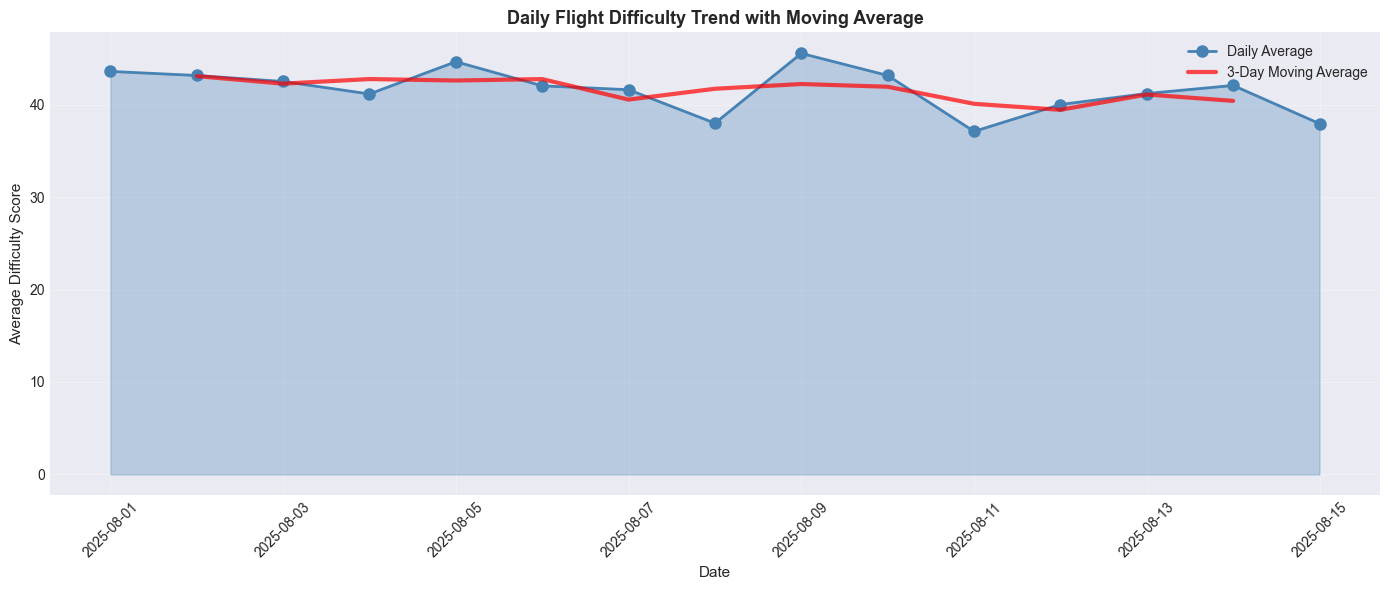

Advanced visualizations created successfully!


In [107]:
# Time Series - Rolling Average Difficulty
daily_stats_sorted = daily_stats.sort_index()
daily_stats_sorted['rolling_avg_difficulty'] = daily_stats_sorted['avg_difficulty'].rolling(window=3, center=True).mean()

plt.figure(figsize=(14, 6))
plt.plot(daily_stats_sorted.index, daily_stats_sorted['avg_difficulty'], 
         marker='o', linewidth=2, markersize=8, label='Daily Average', color='steelblue')
plt.plot(daily_stats_sorted.index, daily_stats_sorted['rolling_avg_difficulty'], 
         linewidth=3, label='3-Day Moving Average', color='red', alpha=0.7)
plt.fill_between(daily_stats_sorted.index, 
                 daily_stats_sorted['avg_difficulty'],
                 alpha=0.3, color='steelblue')
plt.xlabel('Date', fontsize=11)
plt.ylabel('Average Difficulty Score', fontsize=11)
plt.title('Daily Flight Difficulty Trend with Moving Average', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('difficulty_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("Advanced visualizations created successfully!")



In [108]:
# Operational Impact Summary Table
print("\n" + "="*80)
print("OPERATIONAL IMPACT SUMMARY")
print("="*80)

impact_summary = pd.DataFrame({
    'Difficulty Category': ['Difficult', 'Medium', 'Easy'],
    'Flight Count': [
        (master_data['difficulty_category'] == 'Difficult').sum(),
        (master_data['difficulty_category'] == 'Medium').sum(),
        (master_data['difficulty_category'] == 'Easy').sum()
    ],
    'Avg Delay (min)': [
        master_data[master_data['difficulty_category'] == 'Difficult']['departure_delay_minutes'].mean(),
        master_data[master_data['difficulty_category'] == 'Medium']['departure_delay_minutes'].mean(),
        master_data[master_data['difficulty_category'] == 'Easy']['departure_delay_minutes'].mean()
    ],
    'Avg Load Factor': [
        master_data[master_data['difficulty_category'] == 'Difficult']['load_factor'].mean(),
        master_data[master_data['difficulty_category'] == 'Medium']['load_factor'].mean(),
        master_data[master_data['difficulty_category'] == 'Easy']['load_factor'].mean()
    ],
    'Avg Bags/Pax': [
        master_data[master_data['difficulty_category'] == 'Difficult']['bags_per_passenger'].mean(),
        master_data[master_data['difficulty_category'] == 'Medium']['bags_per_passenger'].mean(),
        master_data[master_data['difficulty_category'] == 'Easy']['bags_per_passenger'].mean()
    ],
    'Avg SSR Ratio': [
        master_data[master_data['difficulty_category'] == 'Difficult']['special_service_ratio'].mean(),
        master_data[master_data['difficulty_category'] == 'Medium']['special_service_ratio'].mean(),
        master_data[master_data['difficulty_category'] == 'Easy']['special_service_ratio'].mean()
    ],
    'Tight Turnaround %': [
        (master_data[master_data['difficulty_category'] == 'Difficult']['is_tight_turnaround'].sum() / 
         (master_data['difficulty_category'] == 'Difficult').sum() * 100),
        (master_data[master_data['difficulty_category'] == 'Medium']['is_tight_turnaround'].sum() / 
         (master_data['difficulty_category'] == 'Medium').sum() * 100),
        (master_data[master_data['difficulty_category'] == 'Easy']['is_tight_turnaround'].sum() / 
         (master_data['difficulty_category'] == 'Easy').sum() * 100)
    ]
})

impact_summary = impact_summary.round(2)
print("\n", impact_summary.to_string(index=False))

# Export to CSV
impact_summary.to_csv('operational_impact_summary.csv', index=False)
print("\nOperational impact summary exported to 'operational_impact_summary.csv'")

print("\n" + "="*80)


OPERATIONAL IMPACT SUMMARY

 Difficulty Category  Flight Count  Avg Delay (min)  Avg Load Factor  Avg Bags/Pax  Avg SSR Ratio  Tight Turnaround %
          Difficult          2036            37.13             0.97          0.65           0.02               32.56
             Medium          2829            16.65             0.96          0.60           0.02                3.36
               Easy          3234            15.11             0.89          0.68           0.02                0.68

Operational impact summary exported to 'operational_impact_summary.csv'

